# 1. Import library 

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, Dense, SimpleRNN, LSTM, Dropout, RepeatVector, TimeDistributed, Activation, Flatten, MaxPooling2D
from tensorflow.keras import optimizers

In [97]:
import numpy as np
from scipy.stats import norm
import scipy.optimize as opt
import pandas as pd
import datetime
import time
from arch import arch_model #traditional financial data analysis functions
import matplotlib.pyplot as plt
#from numba import jit
from sklearn.metrics import mean_squared_error as mse
from sklearn import metrics
import warnings
warnings.filterwarnings('ignore')
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from numpy import asarray
from pandas import read_csv
import time
sns.set(style='whitegrid', palette='muted')
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 14, 8

In [3]:
X=pd.read_csv("C:/Users/user/Desktop/ECON4305/Data preprocess/x.csv",header=0, index_col=0)
y=pd.read_csv("C:/Users/user/Desktop/ECON4305/Data preprocess/y.csv",header=0, index_col=0)
y=pd.DataFrame(y["Inflation"])
y

,Inflation
sasdate,
1992-01-05,0.214977
1992-01-06,0.285919
1992-01-07,0.285104
1992-01-08,0.213295
1992-01-09,0.212842
...,...
2023-01-01,0.515742
2023-01-02,0.369323
2023-01-03,0.053028


# PCA

In [4]:
n=[]
var_explained=[]
for n_comp in [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,30,50,100,120,123]:

    steps_X = [('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)),
               ('pca', PCA(n_components = n_comp, random_state=1))]
    
    pl_pca_X = Pipeline(steps_X)
    X_pca_model = pl_pca_X.fit(X)
    n.append(n_comp)
    var_explained.append(X_pca_model.steps[1][1].explained_variance_ratio_.sum())
    print('n_components:', n_comp, '  ', 'variance explained:', '%.3f' %X_pca_model.steps[1][1].explained_variance_ratio_.sum())

PCA(n_components = 20, random_state=1)

n_components: 1    variance explained: 0.223
n_components: 2    variance explained: 0.313
n_components: 3    variance explained: 0.390
n_components: 4    variance explained: 0.450
n_components: 5    variance explained: 0.491
n_components: 6    variance explained: 0.527
n_components: 7    variance explained: 0.555
n_components: 8    variance explained: 0.580
n_components: 9    variance explained: 0.602
n_components: 10    variance explained: 0.623
n_components: 11    variance explained: 0.643
n_components: 12    variance explained: 0.661
n_components: 13    variance explained: 0.678
n_components: 14    variance explained: 0.695
n_components: 15    variance explained: 0.710
n_components: 16    variance explained: 0.723
n_components: 17    variance explained: 0.737
n_components: 18    variance explained: 0.749
n_components: 19    variance explained: 0.761
n_components: 20    variance explained: 0.773
n_components: 30    variance explained: 0.859
n_components: 50    variance explained: 0.9

PCA(n_components=20, random_state=1)

In [49]:
steps_X = [('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)),
           ('pca', PCA(n_components = 40, random_state=1))]

pl_pca_X = Pipeline(steps_X)

X_pca_model = pl_pca_X.fit(X)

print('n_components:', 40, '  ', 'variance explained:', '%.3f' %X_pca_model.steps[1][1].explained_variance_ratio_.sum())

X_pca = X_pca_model.transform(X)

n_components: 40    variance explained: 0.914


In [50]:
X_pca

array([[-0.6385856 ,  1.1982482 ,  2.46121929, ..., -0.62190545,
        -1.68565438, -0.4029994 ],
       [-0.66490779,  1.44221794,  1.61738141, ...,  0.16393169,
        -1.03325051,  0.85877988],
       [ 0.37906653,  1.71332525,  1.45672813, ...,  1.43961215,
        -0.52814187, -1.29137959],
       ...,
       [ 1.03202724, -3.86902959, -0.70764761, ..., -0.97367288,
        -1.24800649, -0.605108  ],
       [ 1.42280971, -4.00205481, -0.26619802, ..., -1.58170546,
        -0.89161108,  0.37166494],
       [-2.79300232,  3.91802463, -3.56991264, ...,  0.6119144 ,
        -0.28817051, -0.33348972]])

# Training Model

In [51]:
train_ratio=0.3
n = int(len(X)*train_ratio)
n_steps = 12
n_features = X_pca.shape[1]


In [52]:
# split a multivariate sequence into samples
def split_sequences(X, n_steps):
    X_seq = list()
    for i in range(len(X)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix > len(X):
            break
        # gather input and output parts of the pattern
        seq_x = X[i:end_ix, :]
        X_seq.append(seq_x)
    return np.array(X_seq)

In [53]:
X_train = split_sequences(X_pca[:-n], n_steps)
#X_train = split_sequences(X.iloc[:-1], n_steps)
X_train.shape # no. of instances, no.of timesteps, no.of features

(251, 12, 40)

In [54]:
y_train = y.iloc[n_steps:-n+1].values
#y_train = y.iloc[n_steps:].values
y_train


array([[ 0.27777796],
       [ 0.06932409],
       [ 0.13850418],
       [ 0.20739724],
       [ 0.13802625],
       [ 0.41293933],
       [ 0.27434859],
       [ 0.20526863],
       [ 0.        ],
       [ 0.27303771],
       [ 0.27229425],
       [ 0.06795787],
       [ 0.20359695],
       [ 0.27081939],
       [ 0.3374961 ],
       [ 0.40349752],
       [ 0.20113986],
       [ 0.06695682],
       [ 0.26737984],
       [ 0.20006676],
       [ 0.26613455],
       [ 0.26542816],
       [ 0.1986098 ],
       [ 0.39604012],
       [ 0.19743343],
       [ 0.1970444 ],
       [ 0.13114756],
       [ 0.19639941],
       [ 0.13071897],
       [ 0.26092644],
       [ 0.13020835],
       [ 0.13003903],
       [ 0.51847167],
       [ 0.19373593],
       [ 0.32206147],
       [ 0.38510959],
       [ 0.19200006],
       [ 0.19163213],
       [ 0.1912656 ],
       [ 0.12730746],
       [ 0.3175614 ],
       [ 0.31655614],
       [ 0.31555722],
       [ 0.25173078],
       [ 0.1883831 ],
       [ 0

In [55]:
X_test = split_sequences(X_pca[-n-n_steps+1:], n_steps)
#X_test = split_sequences(X.iloc[-n-n_steps+1:], n_steps)
X_test.shape

(111, 12, 40)

4/4 [==============================] - 0s 4ms/step
RMSE:  1286887.7871854443
Correlation:            Actual      LSTM
Actual  1.000000 -0.090421
LSTM   -0.090421  1.000000
R2:  -19152674066597.035


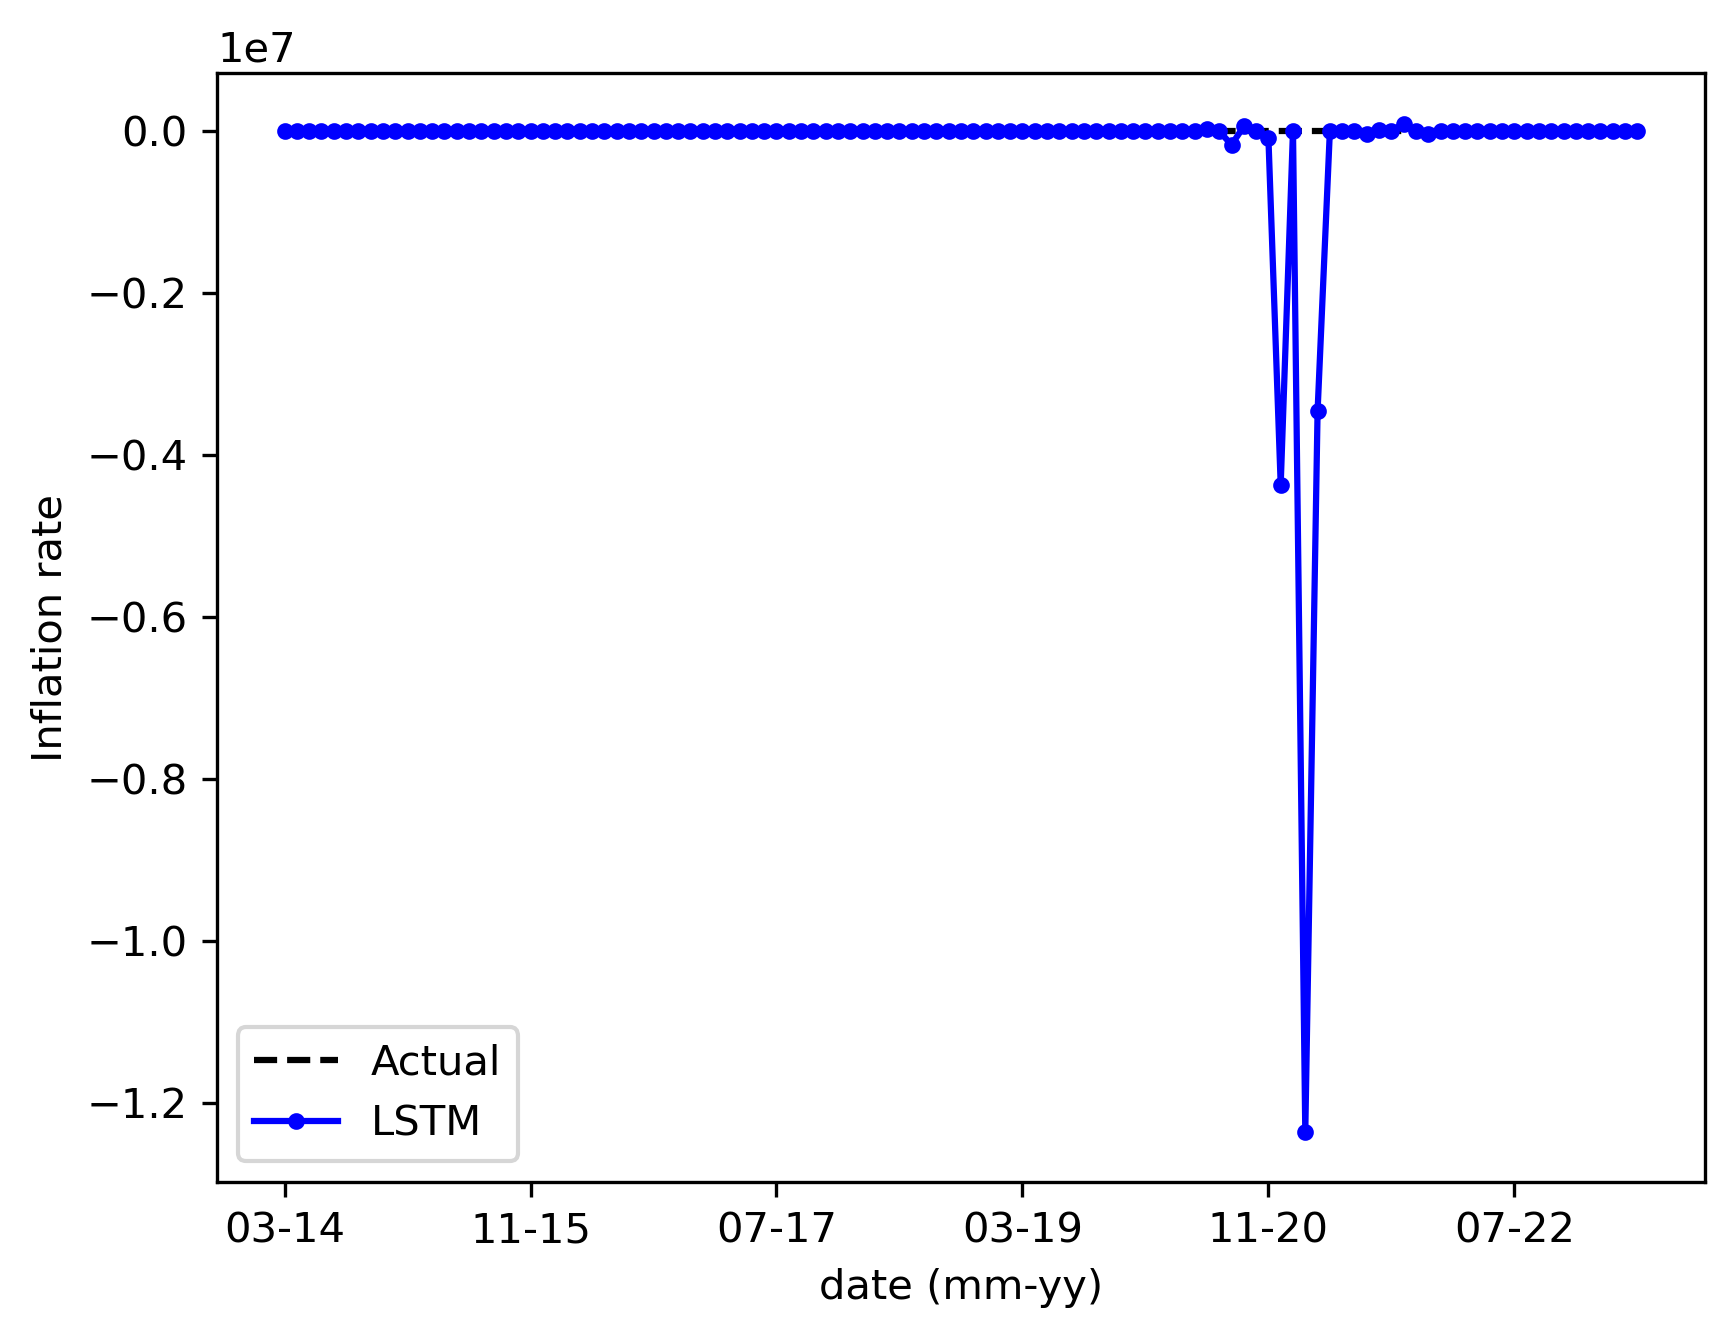

In [82]:
#Define the LSTM model
model = Sequential()
model.add(BatchNormalization())
model.add(LSTM(40, activation='elu', kernel_regularizer="l2", input_shape=(n_steps, n_features)))

#model.add(Dropout(0.2))
#model.add(Dense(40, kernel_regularizer='l1', activation='elu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='linear'))
adam = optimizers.Adam(lr=0.05)
model.compile(optimizer=adam, 
              loss='mean_squared_error',
              metrics=['mse'])
np.random.seed(1)
tf.random.set_seed(2)

#Train the LSTM Model
model_lstm = model.fit(X_train,
                       y_train,
                       batch_size=20, epochs=1000, shuffle=False, verbose=False)

#Predict with test data
LSTM_pred = model.predict(X_test)
LSTM_pred.shape

rmse_lstm = np.sqrt(mse(y.iloc[-n:], LSTM_pred))
rmse_lstm

#Calculate the RMSE, correlation and R2
LSTM_pred=pd.DataFrame(LSTM_pred,index=y.iloc[-n:].index)
results=pd.concat([y.iloc[-n:],LSTM_pred],axis=1,ignore_index=True)
results.columns=["Actual","LSTM"]
results.index = pd.DatetimeIndex(results.index).strftime("%d-%y")

print("RMSE: ", metrics.mean_squared_error(y.iloc[-n:], LSTM_pred,squared=False))
print("Correlation: ",results.corr() )
print("R2: ", metrics.r2_score(y.iloc[-n:], LSTM_pred))


#Plot graph 
(results["Actual"]).plot(color="black",linestyle="--")
(results["LSTM"]).plot(color="blue",marker=".")
plt.legend(["Actual","LSTM"])
plt.xlabel("date (mm-yy)")
plt.ylabel("Inflation rate")
plt.show()

4/4 [==============================] - 0s 4ms/step
RMSE:  0.30539321924729995
Correlation:            Actual      LSTM
Actual  1.000000  0.180084
LSTM    0.180084  1.000000
R2:  -0.07861595321491532


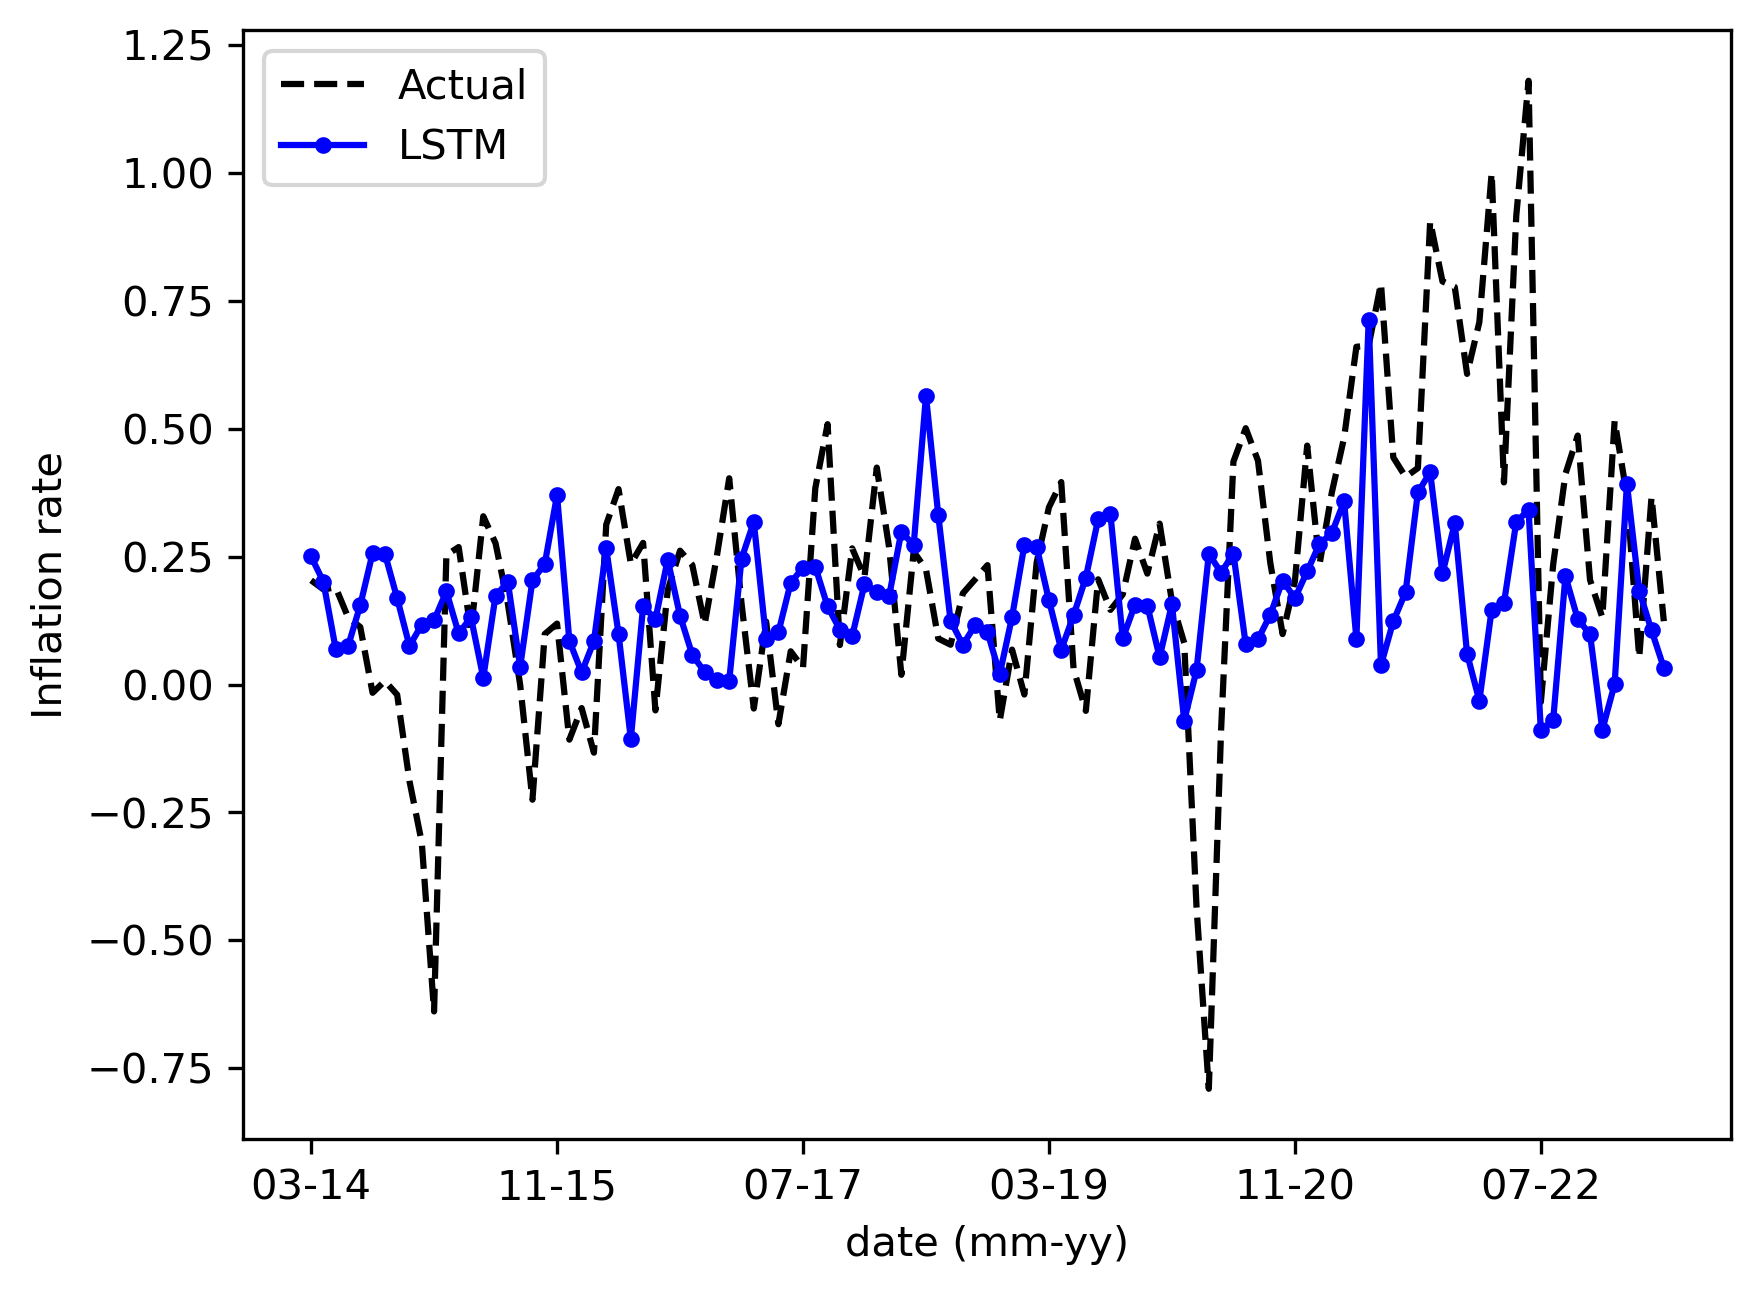

In [81]:
#Define the LSTM model
model = Sequential()
model.add(BatchNormalization())
model.add(LSTM(40, activation='elu', kernel_regularizer="l2", input_shape=(n_steps, n_features)))

model.add(Dropout(0.2))
model.add(Dense(1, activation='linear'))
adam = optimizers.Adam(lr=0.005)
model.compile(optimizer=adam, 
              loss='mean_squared_error',
              metrics=['mse'])
np.random.seed(1)
tf.random.set_seed(2)

#Train the LSTM Model
model_lstm = model.fit(X_train,
                       y_train,
                       batch_size=20, epochs=1000, shuffle=False, verbose=False)

#Predict with test data
LSTM_pred = model.predict(X_test)
LSTM_pred.shape

rmse_lstm = np.sqrt(mse(y.iloc[-n:], LSTM_pred))
rmse_lstm

#Calculate the RMSE, correlation and R2
LSTM_pred=pd.DataFrame(LSTM_pred,index=y.iloc[-n:].index)
results=pd.concat([y.iloc[-n:],LSTM_pred],axis=1,ignore_index=True)
results.columns=["Actual","LSTM"]
results.index = pd.DatetimeIndex(results.index).strftime("%d-%y")

print("RMSE: ", metrics.mean_squared_error(y.iloc[-n:], LSTM_pred,squared=False))
print("Correlation: ",results.corr() )
print("R2: ", metrics.r2_score(y.iloc[-n:], LSTM_pred))


#Plot graph 
(results["Actual"]).plot(color="black",linestyle="--")
(results["LSTM"]).plot(color="blue",marker=".")
plt.legend(["Actual","LSTM"])
plt.xlabel("date (mm-yy)")
plt.ylabel("Inflation rate")
plt.show()

4/4 [==============================] - 0s 3ms/step
RMSE:  0.37548042718762864
Correlation:            Actual      LSTM
Actual  1.000000 -0.052011
LSTM   -0.052011  1.000000
R2:  -0.6305069936037933


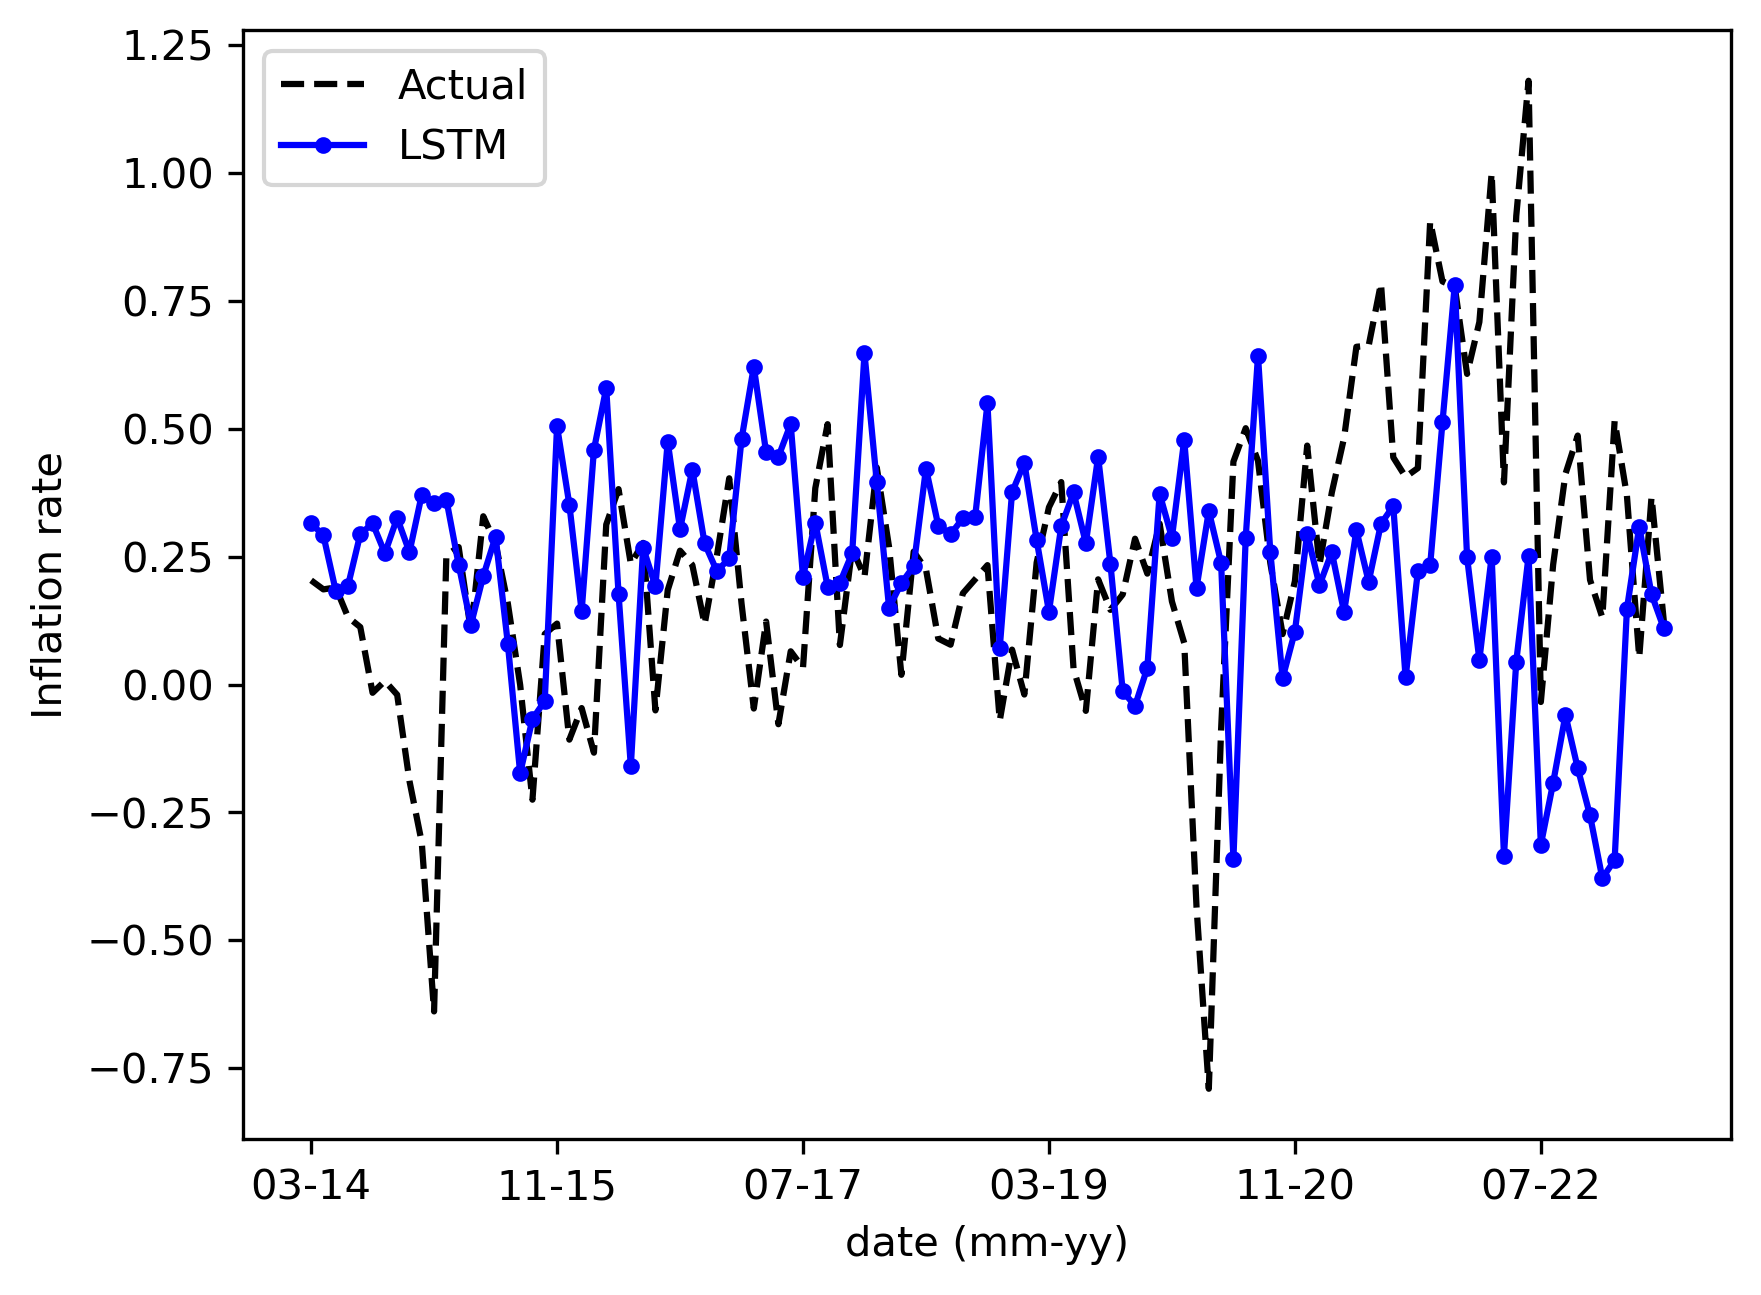

In [83]:
#Define the LSTM model
model = Sequential()
model.add(BatchNormalization())
model.add(LSTM(40, activation='elu', kernel_regularizer="l2", input_shape=(n_steps, n_features)))
model.add(Dropout(0.2))
model.add(Dense(1, activation='linear'))
adam = optimizers.Adam(lr=0.001)
model.compile(optimizer=adam, 
              loss='mean_squared_error',
              metrics=['mse'])
np.random.seed(1)
tf.random.set_seed(2)

#Train the LSTM Model
model_lstm = model.fit(X_train,
                       y_train,
                       batch_size=20, epochs=1000, shuffle=False, verbose=False)

#Predict with test data
LSTM_pred = model.predict(X_test)
LSTM_pred.shape

rmse_lstm = np.sqrt(mse(y.iloc[-n:], LSTM_pred))
rmse_lstm

#Calculate the RMSE, correlation and R2
LSTM_pred=pd.DataFrame(LSTM_pred,index=y.iloc[-n:].index)
results=pd.concat([y.iloc[-n:],LSTM_pred],axis=1,ignore_index=True)
results.columns=["Actual","LSTM"]
results.index = pd.DatetimeIndex(results.index).strftime("%d-%y")

print("RMSE: ", metrics.mean_squared_error(y.iloc[-n:], LSTM_pred,squared=False))
print("Correlation: ",results.corr() )
print("R2: ", metrics.r2_score(y.iloc[-n:], LSTM_pred))


#Plot graph 
(results["Actual"]).plot(color="black",linestyle="--")
(results["LSTM"]).plot(color="blue",marker=".")
plt.legend(["Actual","LSTM"])
plt.xlabel("date (mm-yy)")
plt.ylabel("Inflation rate")
plt.show()

4/4 [==============================] - 0s 3ms/step
RMSE:  0.334834546644821
Correlation:            Actual      LSTM
Actual  1.000000  0.058703
LSTM    0.058703  1.000000
R2:  -0.29660764967364406


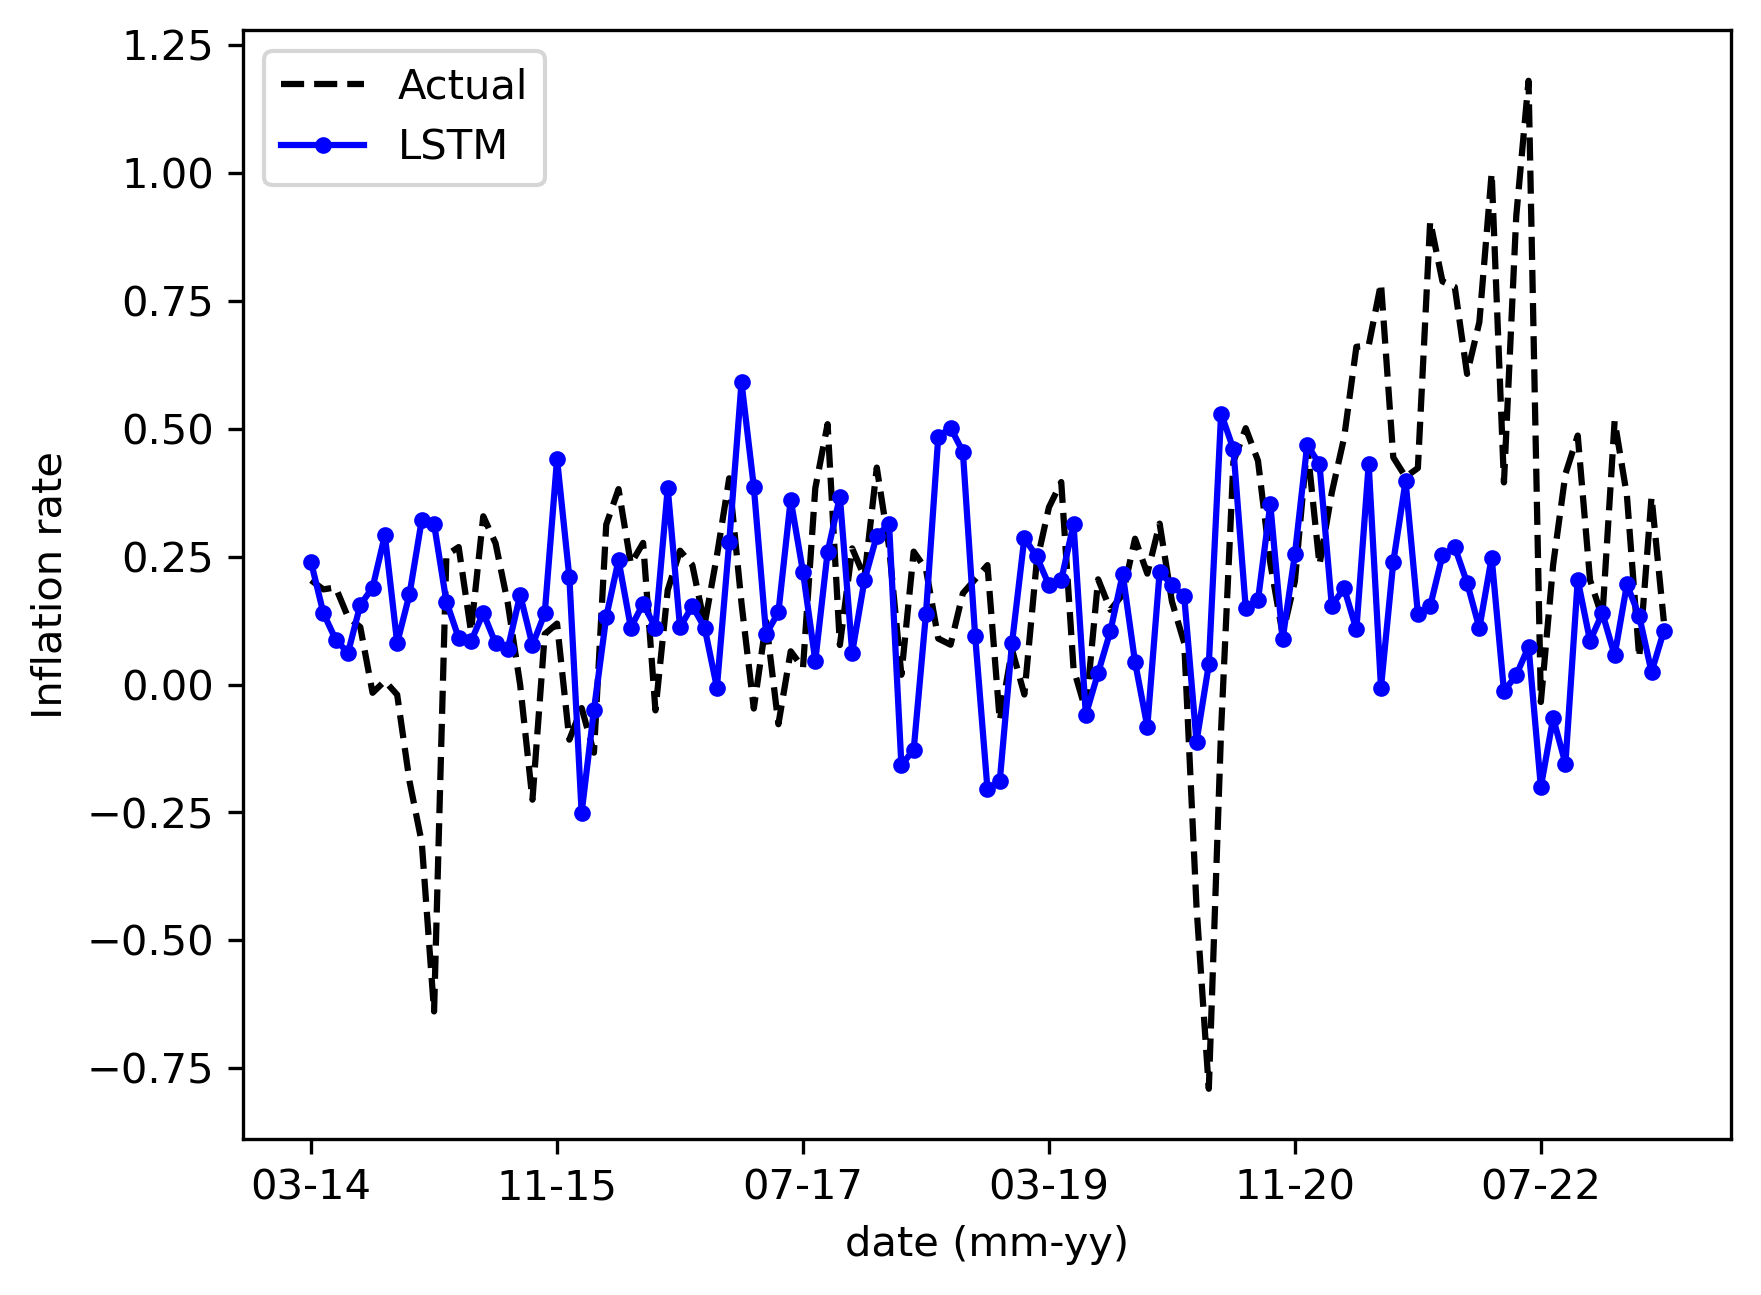

In [90]:
#Define the LSTM model
model = Sequential()
model.add(BatchNormalization()) # Normalization 
model.add(LSTM(40, activation='elu', kernel_regularizer="l2", input_shape=(n_steps, n_features)))

model.add(Dropout(0.2))
model.add(Dense(1, activation='linear'))
adam = optimizers.Adam(lr=0.005)
model.compile(optimizer=adam, 
              loss='mean_squared_error',
              metrics=['mse'])
np.random.seed(1)
tf.random.set_seed(2)

#Train the LSTM Model
model_lstm = model.fit(X_train,
                       y_train,
                       batch_size=20, epochs=1000, shuffle=False, verbose=False)

#Predict with test data
LSTM_pred = model.predict(X_test)
LSTM_pred.shape

rmse_lstm = np.sqrt(mse(y.iloc[-n:], LSTM_pred))
rmse_lstm

#Calculate the RMSE, correlation and R2
LSTM_pred=pd.DataFrame(LSTM_pred,index=y.iloc[-n:].index)
results=pd.concat([y.iloc[-n:],LSTM_pred],axis=1,ignore_index=True)
results.columns=["Actual","LSTM"]
results.index = pd.DatetimeIndex(results.index).strftime("%d-%y")

print("RMSE: ", metrics.mean_squared_error(y.iloc[-n:], LSTM_pred,squared=False))
print("Correlation: ",results.corr() )
print("R2: ", metrics.r2_score(y.iloc[-n:], LSTM_pred))


#Plot graph 
(results["Actual"]).plot(color="black",linestyle="--")
(results["LSTM"]).plot(color="blue",marker=".")
plt.legend(["Actual","LSTM"])
plt.xlabel("date (mm-yy)")
plt.ylabel("Inflation rate")
plt.show()

8/8 [==============================] - 0s 8ms/step
RMSE:  0.33556584978139925
Correlation:            Actual      LSTM
Actual  1.000000  0.021259
LSTM    0.021259  1.000000
R2:  -0.30227760657719926


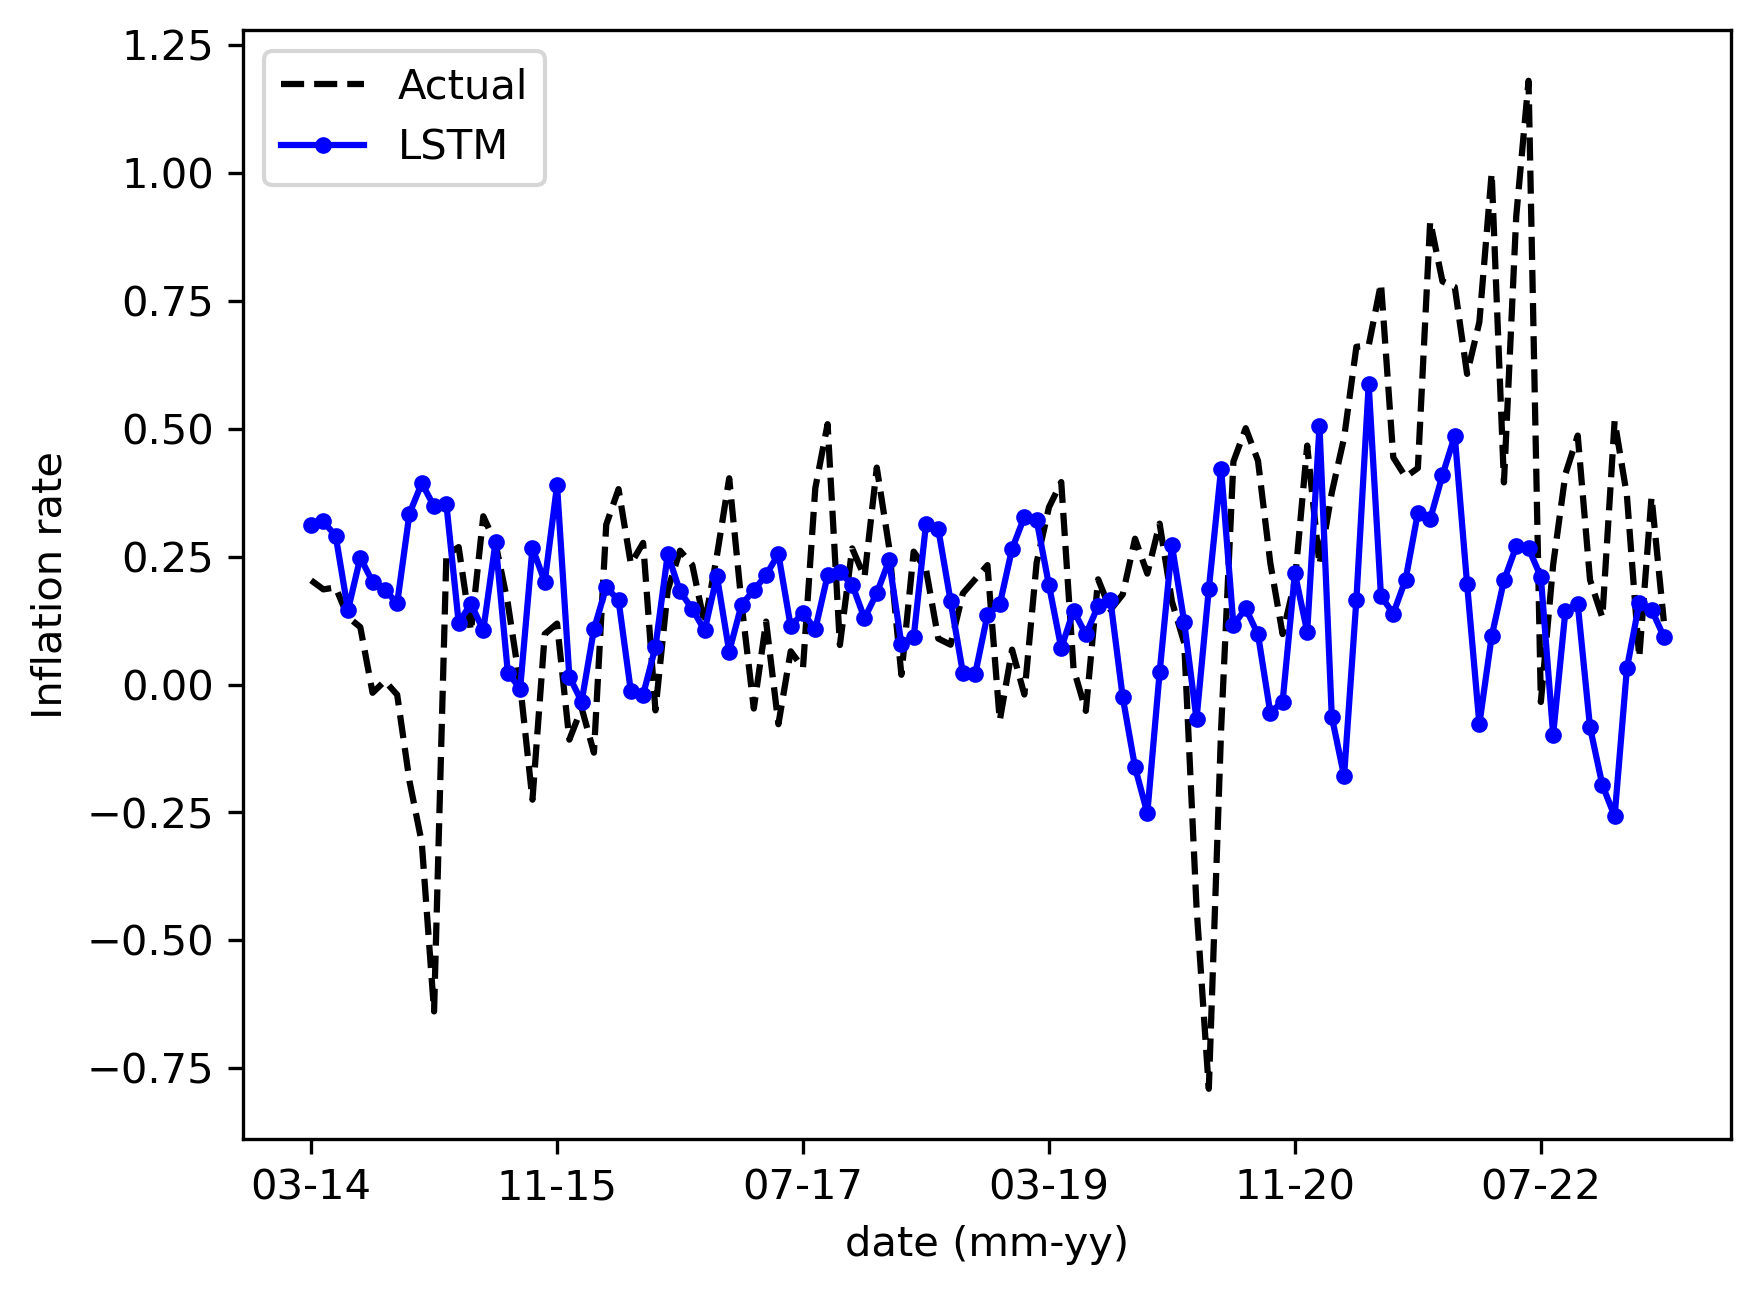

In [93]:
#Define the LSTM model
model = Sequential()
model.add(BatchNormalization())
model.add(LSTM(40, activation='elu', kernel_regularizer="l2", input_shape=(n_steps, n_features)))

model.add(Dropout(0.2))
model.add(Dense(1, activation='linear'))
adam = optimizers.Adam(lr=0.005)
model.compile(optimizer=adam, 
              loss='mean_squared_error',
              metrics=['mse'])
np.random.seed(1)
tf.random.set_seed(2)

#Train the LSTM Model
model_lstm = model.fit(X_train,
                       y_train,
                       batch_size=20, epochs=1000, shuffle=False, verbose=False)

#Predict with test data
LSTM_pred = model.predict(X_test)
LSTM_pred.shape
LSTM_train_pred = model.predict(X_train)

rmse_lstm = np.sqrt(mse(y.iloc[-n:], LSTM_pred))
rmse_lstm

#Calculate the RMSE, correlation and R2
LSTM_pred=pd.DataFrame(LSTM_pred,index=y.iloc[-n:].index)
results=pd.concat([y.iloc[-n:],LSTM_pred],axis=1,ignore_index=True)
results.columns=["Actual","LSTM"]
results.index = pd.DatetimeIndex(results.index).strftime("%d-%y")


print("RMSE: ", metrics.mean_squared_error(y.iloc[-n:], LSTM_pred,squared=False))
print("Correlation: ",results.corr() )
print("R2: ", metrics.r2_score(y.iloc[-n:], LSTM_pred))


#Plot graph 
(results["Actual"]).plot(color="black",linestyle="--")
(results["LSTM"]).plot(color="blue",marker=".")
plt.legend(["Actual","LSTM"])
plt.xlabel("date (mm-yy)")
plt.ylabel("Inflation rate")
plt.show()

8/8 [==============================] - 0s 12ms/step
test error:  0.3275013388960213
train error 0.1492119857633599
Correlation:            Actual      LSTM
Actual  1.000000 -0.007961
LSTM   -0.007961  1.000000
R2:  -0.24043559189456176


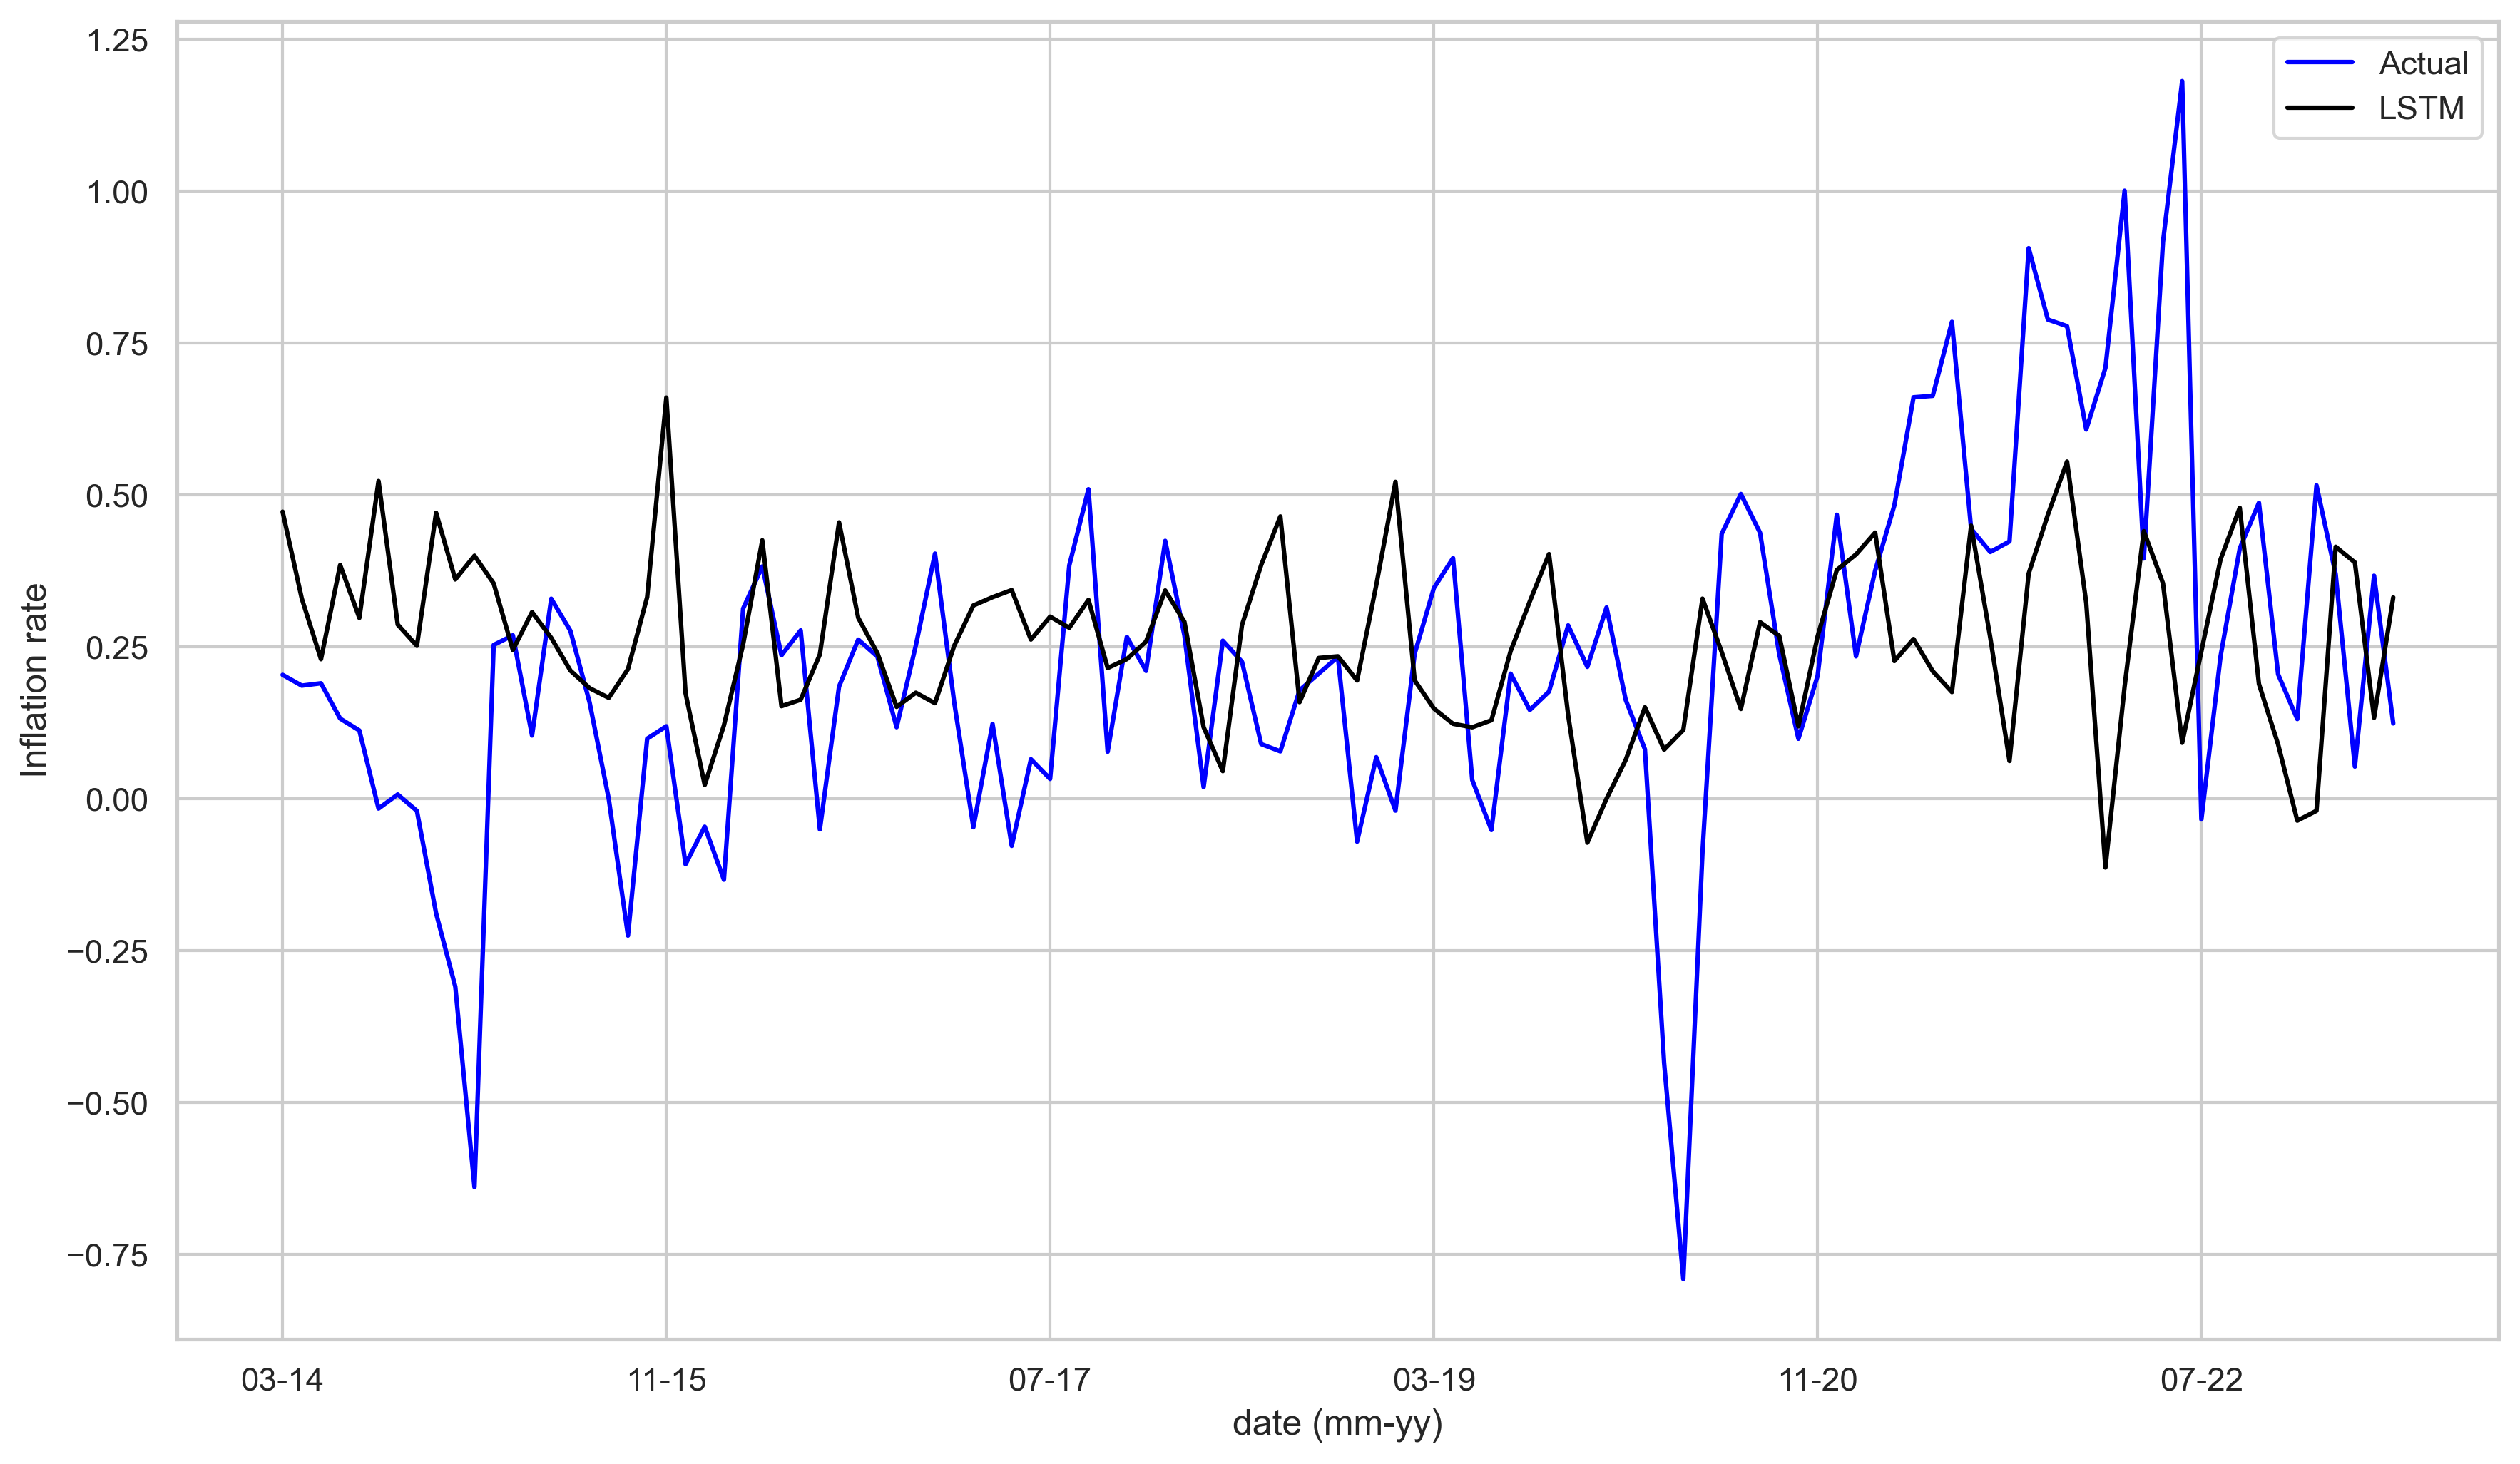

In [110]:
#Define the LSTM model
model = Sequential()
model.add(BatchNormalization())
model.add(LSTM(40, activation='elu', kernel_regularizer="l2", input_shape=(n_steps, n_features)))

model.add(Dropout(0.1))
model.add(Dense(1, activation='linear'))
adam = optimizers.Adam(lr=0.005)
model.compile(optimizer=adam, 
              loss='mean_squared_error',
              metrics=['mse'])
np.random.seed(1)
tf.random.set_seed(2)

#Train the LSTM Model
model_lstm = model.fit(X_train,
                       y_train,
                       batch_size=20, epochs=1000, shuffle=False, verbose=False)

#Predict with test data
LSTM_pred = model.predict(X_test)
LSTM_pred.shape
LSTM_train_pred = model.predict(X_train)

rmse_lstm = np.sqrt(mse(y.iloc[-n:], LSTM_pred))
rmse_lstm

#Calculate the RMSE, correlation and R2
LSTM_pred=pd.DataFrame(LSTM_pred,index=y.iloc[-n:].index)
results=pd.concat([y.iloc[-n:],LSTM_pred],axis=1,ignore_index=True)
results.columns=["Actual","LSTM"]
results.index = pd.DatetimeIndex(results.index).strftime("%d-%y")

print("test error: ", metrics.mean_squared_error(y.iloc[-n:], LSTM_pred,squared=False))
print("train error", metrics.mean_squared_error(y.iloc[:-n-n_steps+1], LSTM_train_pred))
print("Correlation: ",results.corr() )
print("R2: ", metrics.r2_score(y.iloc[-n:], LSTM_pred))


#Plot graph 
(results["Actual"]).plot(color="blue")
(results["LSTM"]).plot(color="black")
plt.legend(["Actual","LSTM"])
plt.xlabel("date (mm-yy)")
plt.ylabel("Inflation rate")
plt.grid(True)
plt.show()

8/8 [==============================] - 0s 4ms/step
test error:  0.3399806840335821
train error 0.16136820034461824
Correlation:            Actual      LSTM
Actual  1.000000  0.072009
LSTM    0.072009  1.000000
R2:  -0.3367695553694652


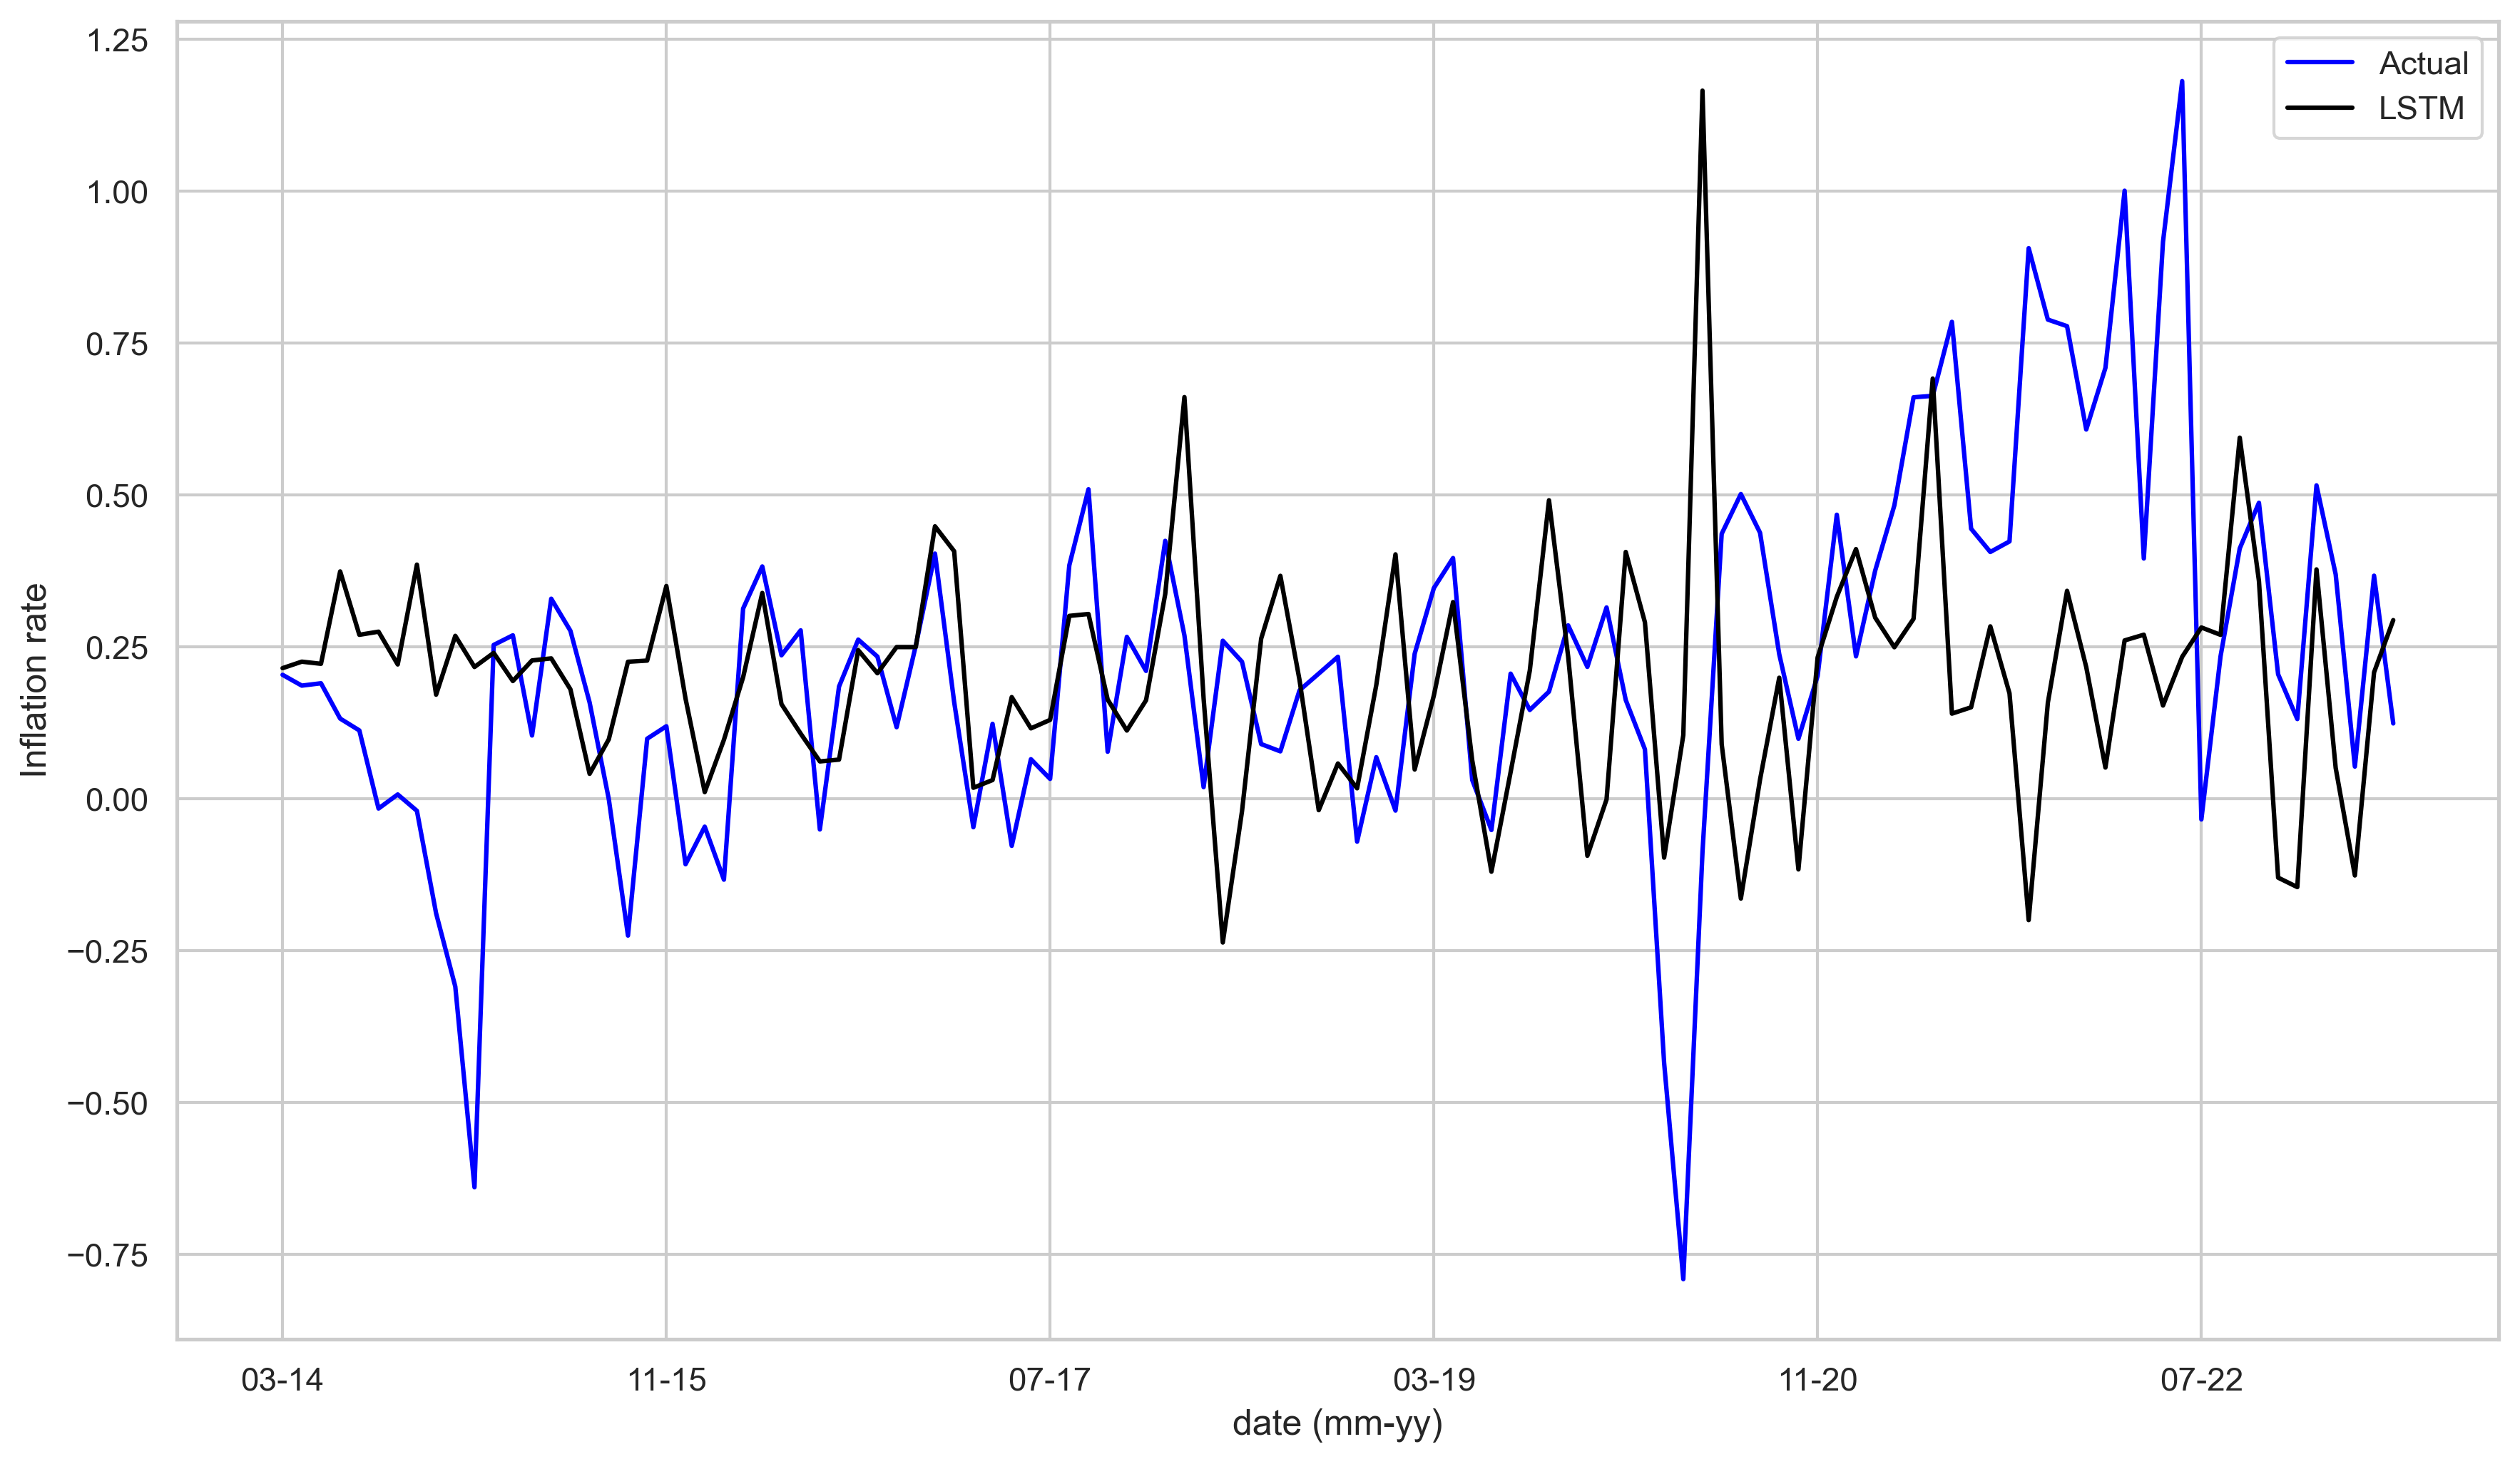

In [112]:
#Define the LSTM model
model = Sequential()
model.add(BatchNormalization())
model.add(LSTM(40, activation='elu', kernel_regularizer="l2", input_shape=(n_steps, n_features)))

model.add(Dropout(0.3))
model.add(Dense(1, activation='linear'))
adam = optimizers.Adam(lr=0.005)
model.compile(optimizer=adam, 
              loss='mean_squared_error',
              metrics=['mse'])
np.random.seed(1)
tf.random.set_seed(2)

#Train the LSTM Model
model_lstm = model.fit(X_train,
                       y_train,
                       batch_size=20, epochs=1000, shuffle=False, verbose=False)

#Predict with test data
LSTM_pred = model.predict(X_test)
LSTM_pred.shape
LSTM_train_pred = model.predict(X_train)

rmse_lstm = np.sqrt(mse(y.iloc[-n:], LSTM_pred))
rmse_lstm

#Calculate the RMSE, correlation and R2
LSTM_pred=pd.DataFrame(LSTM_pred,index=y.iloc[-n:].index)
results=pd.concat([y.iloc[-n:],LSTM_pred],axis=1,ignore_index=True)
results.columns=["Actual","LSTM"]
results.index = pd.DatetimeIndex(results.index).strftime("%d-%y")

print("test error: ", metrics.mean_squared_error(y.iloc[-n:], LSTM_pred,squared=False))
print("train error", metrics.mean_squared_error(y.iloc[:-n-n_steps+1], LSTM_train_pred))
print("Correlation: ",results.corr() )
print("R2: ", metrics.r2_score(y.iloc[-n:], LSTM_pred))


#Plot graph 
(results["Actual"]).plot(color="blue")
(results["LSTM"]).plot(color="black")
plt.legend(["Actual","LSTM"])
plt.xlabel("date (mm-yy)")
plt.ylabel("Inflation rate")
plt.grid(True)
plt.show()

8/8 [==============================] - 0s 4ms/step
test error:  98.38866333350725
train error 546245.2388143038
Correlation:            Actual      LSTM
Actual  1.000000 -0.052182
LSTM   -0.052182  1.000000
R2:  -111952.63013251382


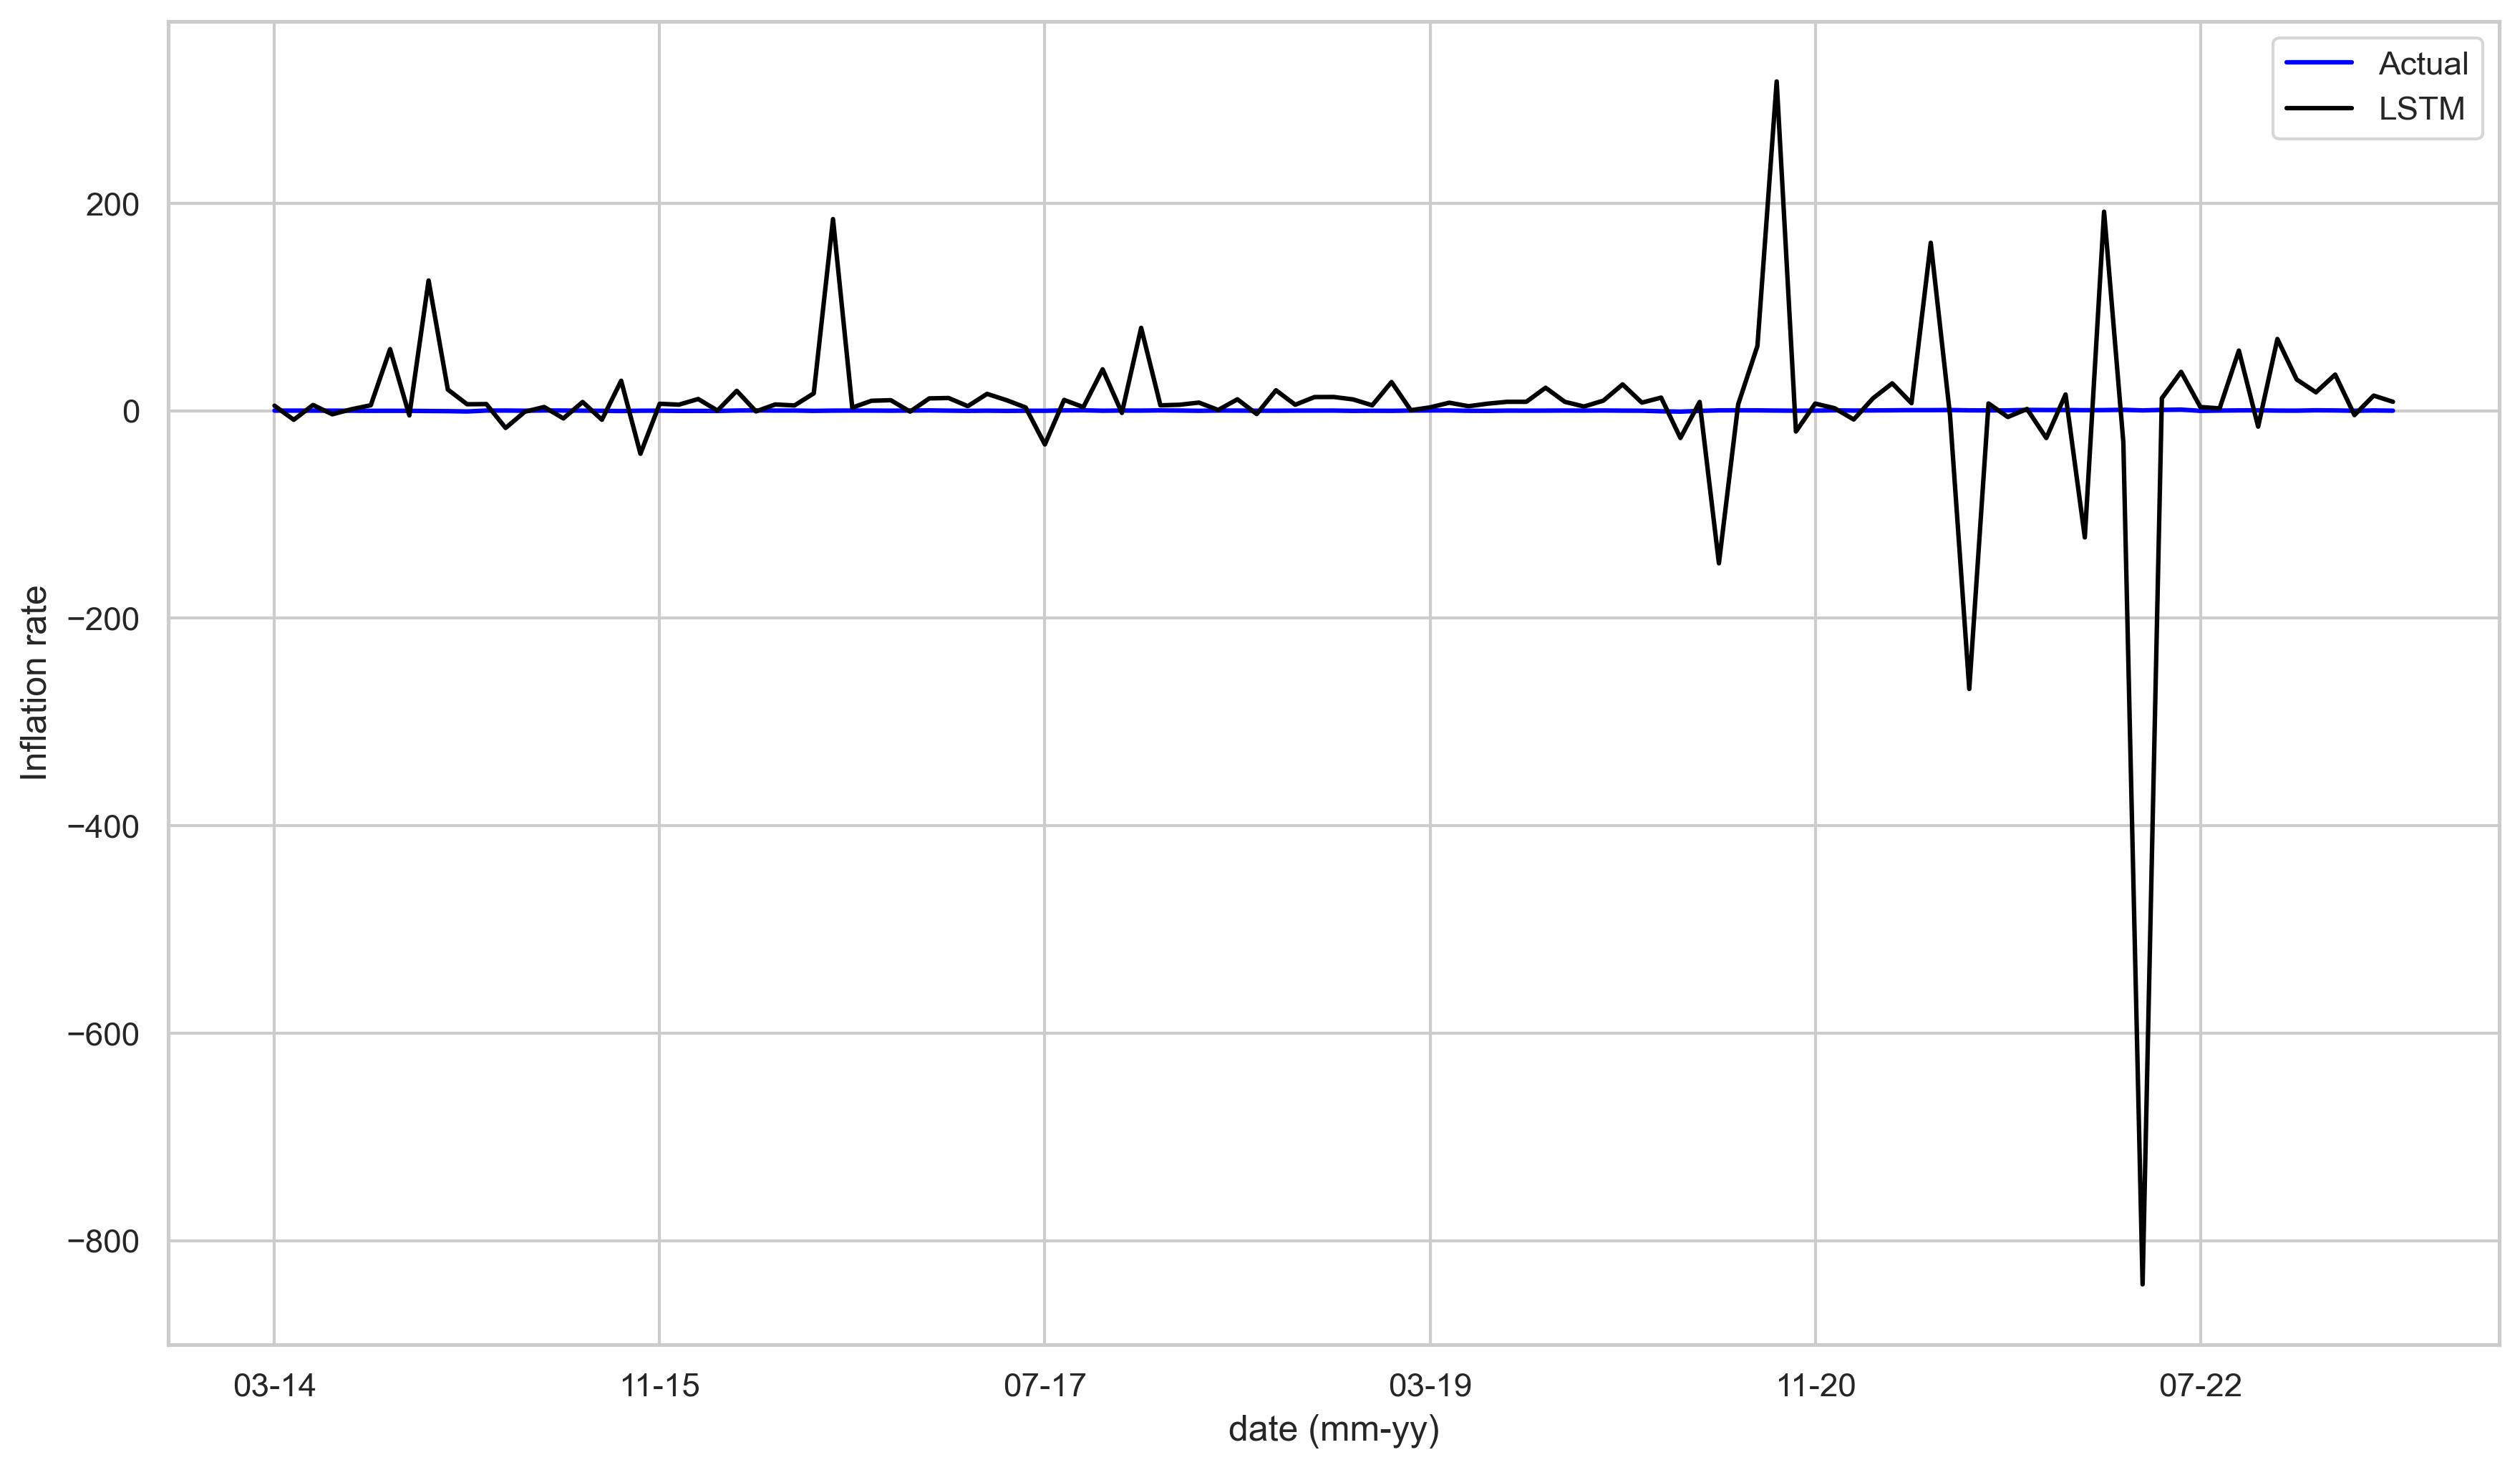

In [113]:
#Define the LSTM model
model = Sequential()
model.add(BatchNormalization())
model.add(LSTM(40, activation='elu', kernel_regularizer="l2", input_shape=(n_steps, n_features)))

model.add(Dropout(0.2))
model.add(Dense(1, activation='linear'))
adam = optimizers.Adam(lr=0.05)
model.compile(optimizer=adam, 
              loss='mean_squared_error',
              metrics=['mse'])
np.random.seed(1)
tf.random.set_seed(2)

#Train the LSTM Model
model_lstm = model.fit(X_train,
                       y_train,
                       batch_size=20, epochs=1000, shuffle=False, verbose=False)

#Predict with test data
LSTM_pred = model.predict(X_test)
LSTM_pred.shape
LSTM_train_pred = model.predict(X_train)

rmse_lstm = np.sqrt(mse(y.iloc[-n:], LSTM_pred))
rmse_lstm

#Calculate the RMSE, correlation and R2
LSTM_pred=pd.DataFrame(LSTM_pred,index=y.iloc[-n:].index)
results=pd.concat([y.iloc[-n:],LSTM_pred],axis=1,ignore_index=True)
results.columns=["Actual","LSTM"]
results.index = pd.DatetimeIndex(results.index).strftime("%d-%y")

print("test error: ", metrics.mean_squared_error(y.iloc[-n:], LSTM_pred,squared=False))
print("train error", metrics.mean_squared_error(y.iloc[:-n-n_steps+1], LSTM_train_pred))
print("Correlation: ",results.corr() )
print("R2: ", metrics.r2_score(y.iloc[-n:], LSTM_pred))


#Plot graph 
(results["Actual"]).plot(color="blue")
(results["LSTM"]).plot(color="black")
plt.legend(["Actual","LSTM"])
plt.xlabel("date (mm-yy)")
plt.ylabel("Inflation rate")
plt.grid(True)
plt.show()

8/8 [==============================] - 0s 4ms/step
test error:  0.7148063938645415
train error 0.28964401807240475
Correlation:            Actual      LSTM
Actual  1.000000 -0.124502
LSTM   -0.124502  1.000000
R2:  -4.909148667500142


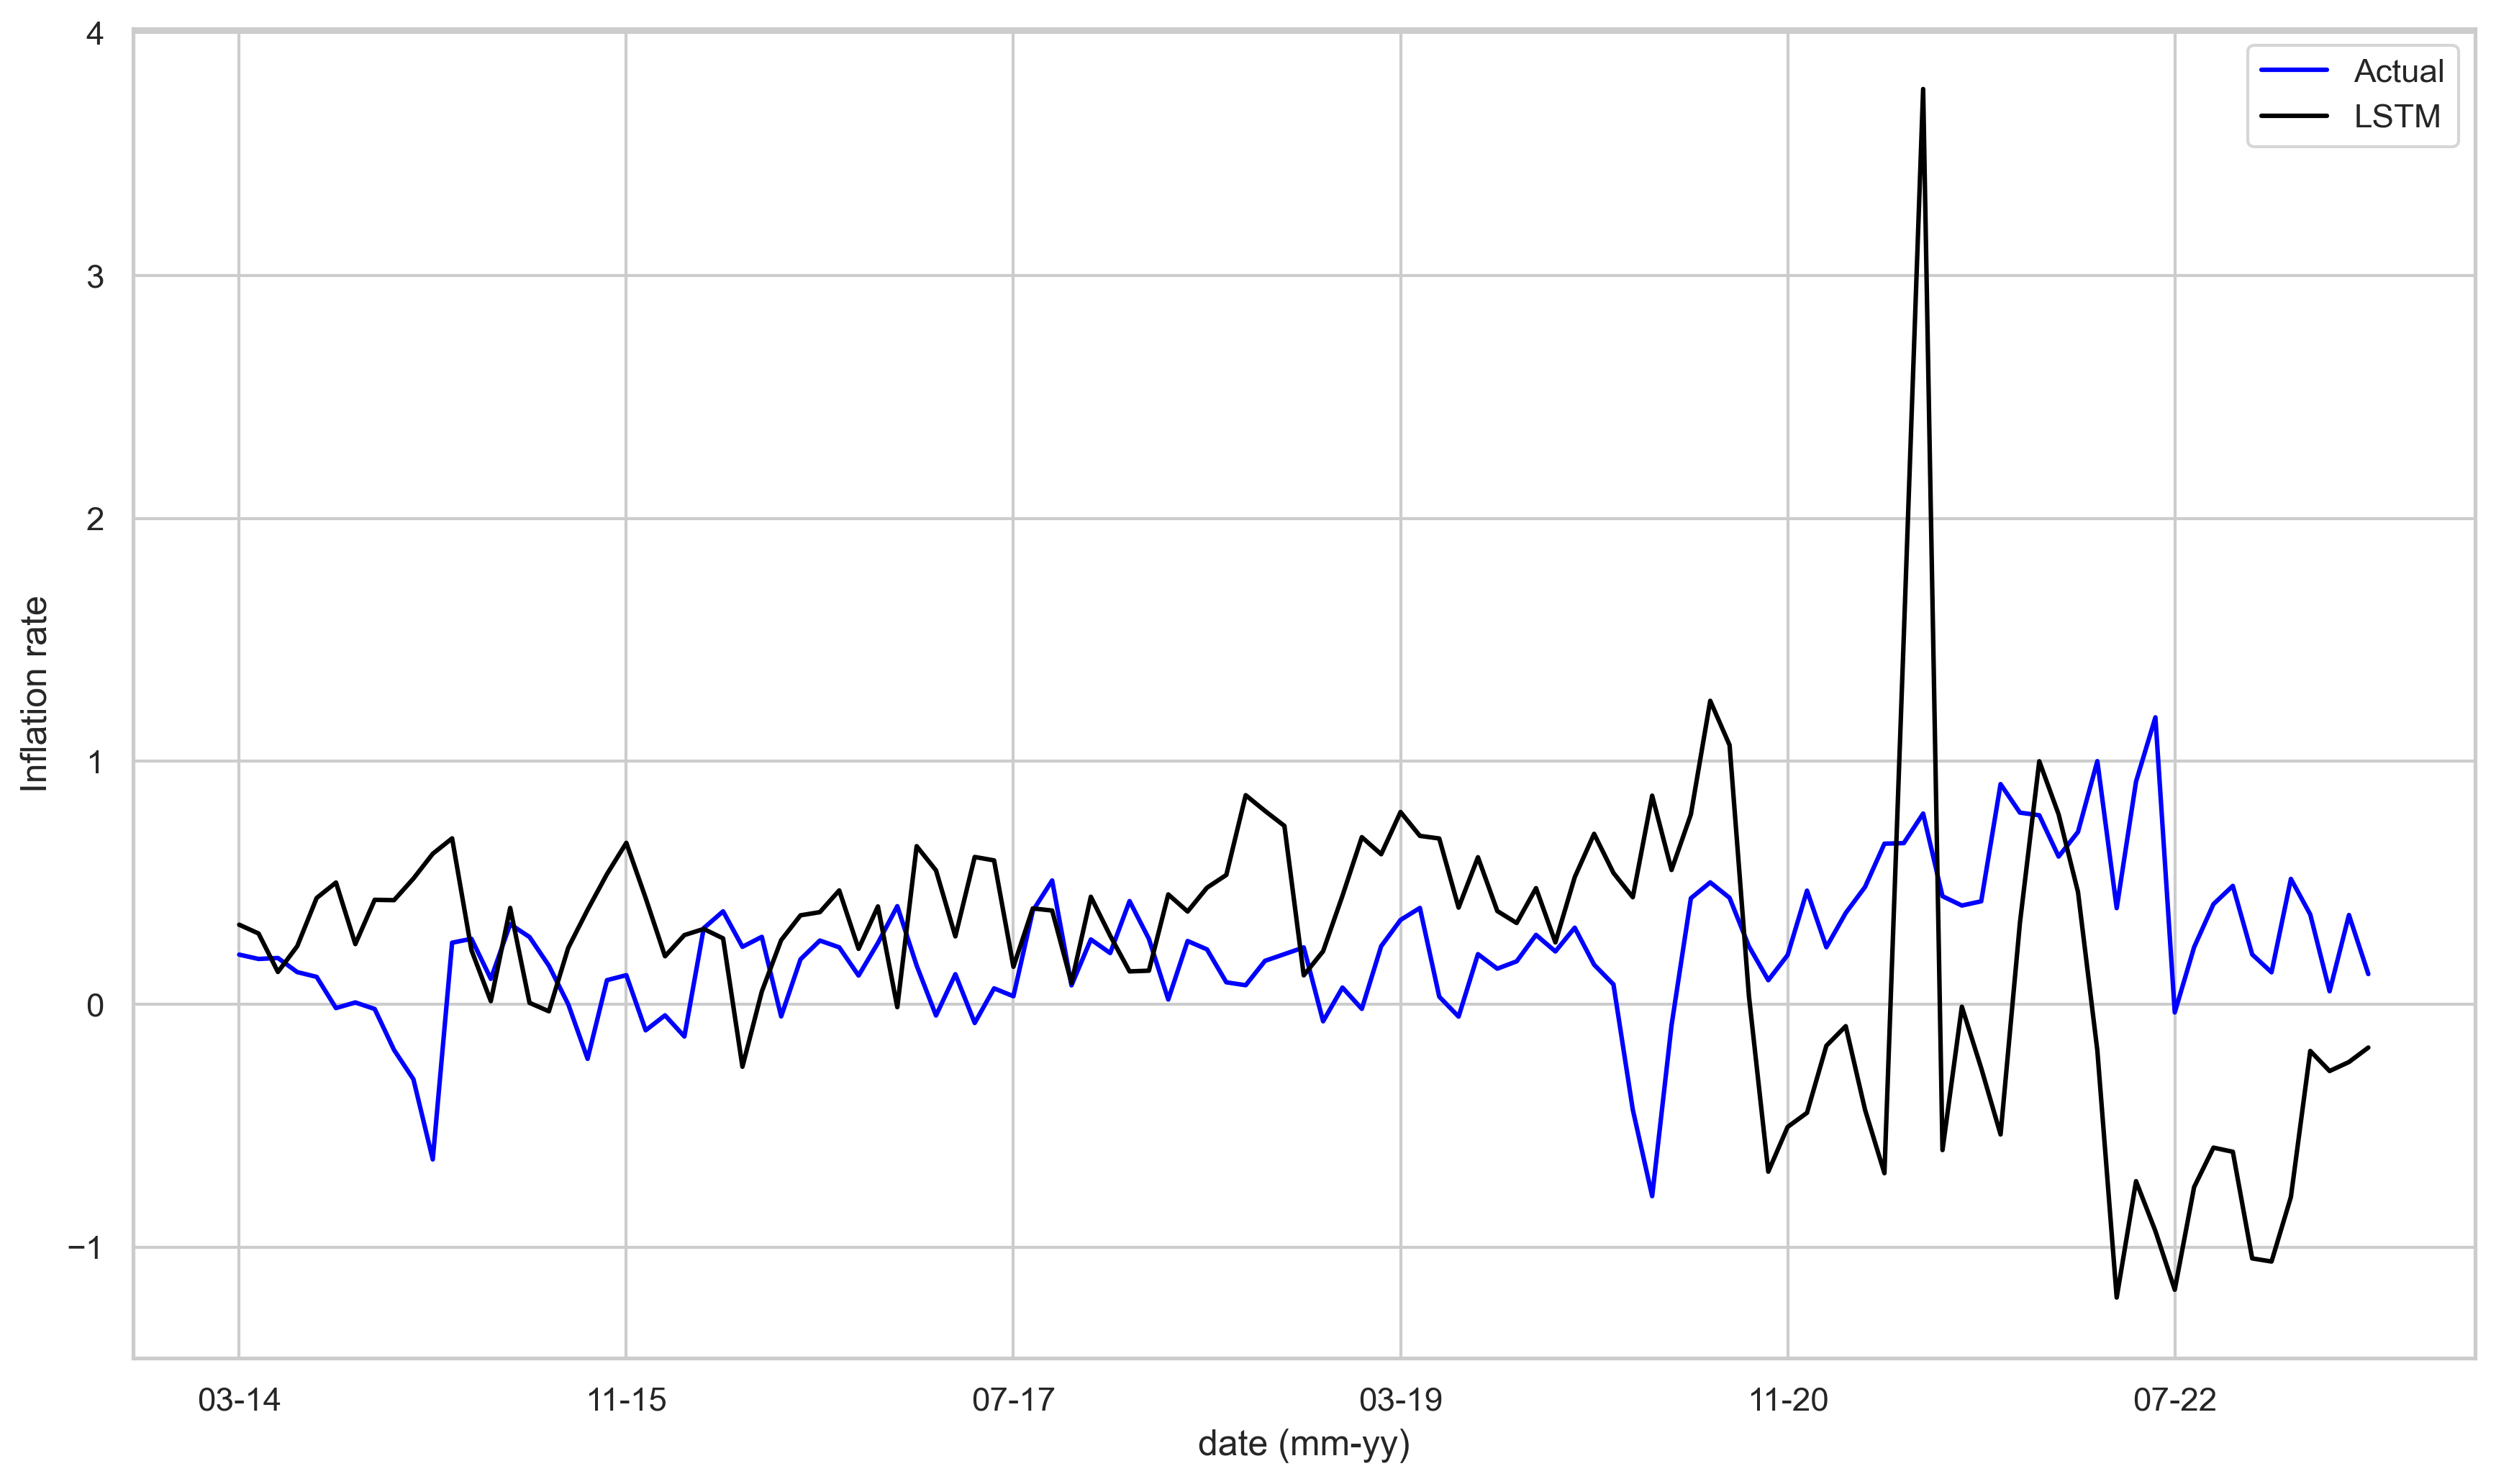

In [114]:
#Define the LSTM model
model = Sequential()
model.add(BatchNormalization())
model.add(LSTM(40, activation='elu', kernel_regularizer="l2", input_shape=(n_steps, n_features)))

model.add(Dropout(0.2))
model.add(Dense(1, activation='linear'))
adam = optimizers.Adam(lr=0.0005)
model.compile(optimizer=adam, 
              loss='mean_squared_error',
              metrics=['mse'])
np.random.seed(1)
tf.random.set_seed(2)

#Train the LSTM Model
model_lstm = model.fit(X_train,
                       y_train,
                       batch_size=20, epochs=1000, shuffle=False, verbose=False)

#Predict with test data
LSTM_pred = model.predict(X_test)
LSTM_pred.shape
LSTM_train_pred = model.predict(X_train)

rmse_lstm = np.sqrt(mse(y.iloc[-n:], LSTM_pred))
rmse_lstm

#Calculate the RMSE, correlation and R2
LSTM_pred=pd.DataFrame(LSTM_pred,index=y.iloc[-n:].index)
results=pd.concat([y.iloc[-n:],LSTM_pred],axis=1,ignore_index=True)
results.columns=["Actual","LSTM"]
results.index = pd.DatetimeIndex(results.index).strftime("%d-%y")

print("test error: ", metrics.mean_squared_error(y.iloc[-n:], LSTM_pred,squared=False))
print("train error", metrics.mean_squared_error(y.iloc[:-n-n_steps+1], LSTM_train_pred))
print("Correlation: ",results.corr() )
print("R2: ", metrics.r2_score(y.iloc[-n:], LSTM_pred))


#Plot graph 
(results["Actual"]).plot(color="blue")
(results["LSTM"]).plot(color="black")
plt.legend(["Actual","LSTM"])
plt.xlabel("date (mm-yy)")
plt.ylabel("Inflation rate")
plt.grid(True)
plt.show()

8/8 [==============================] - 0s 3ms/step
test error:  0.305696389247322
train error 0.14953298710409116
Correlation:            Actual      LSTM
Actual  1.000000  0.220195
LSTM    0.220195  1.000000
R2:  -0.08075854374848546


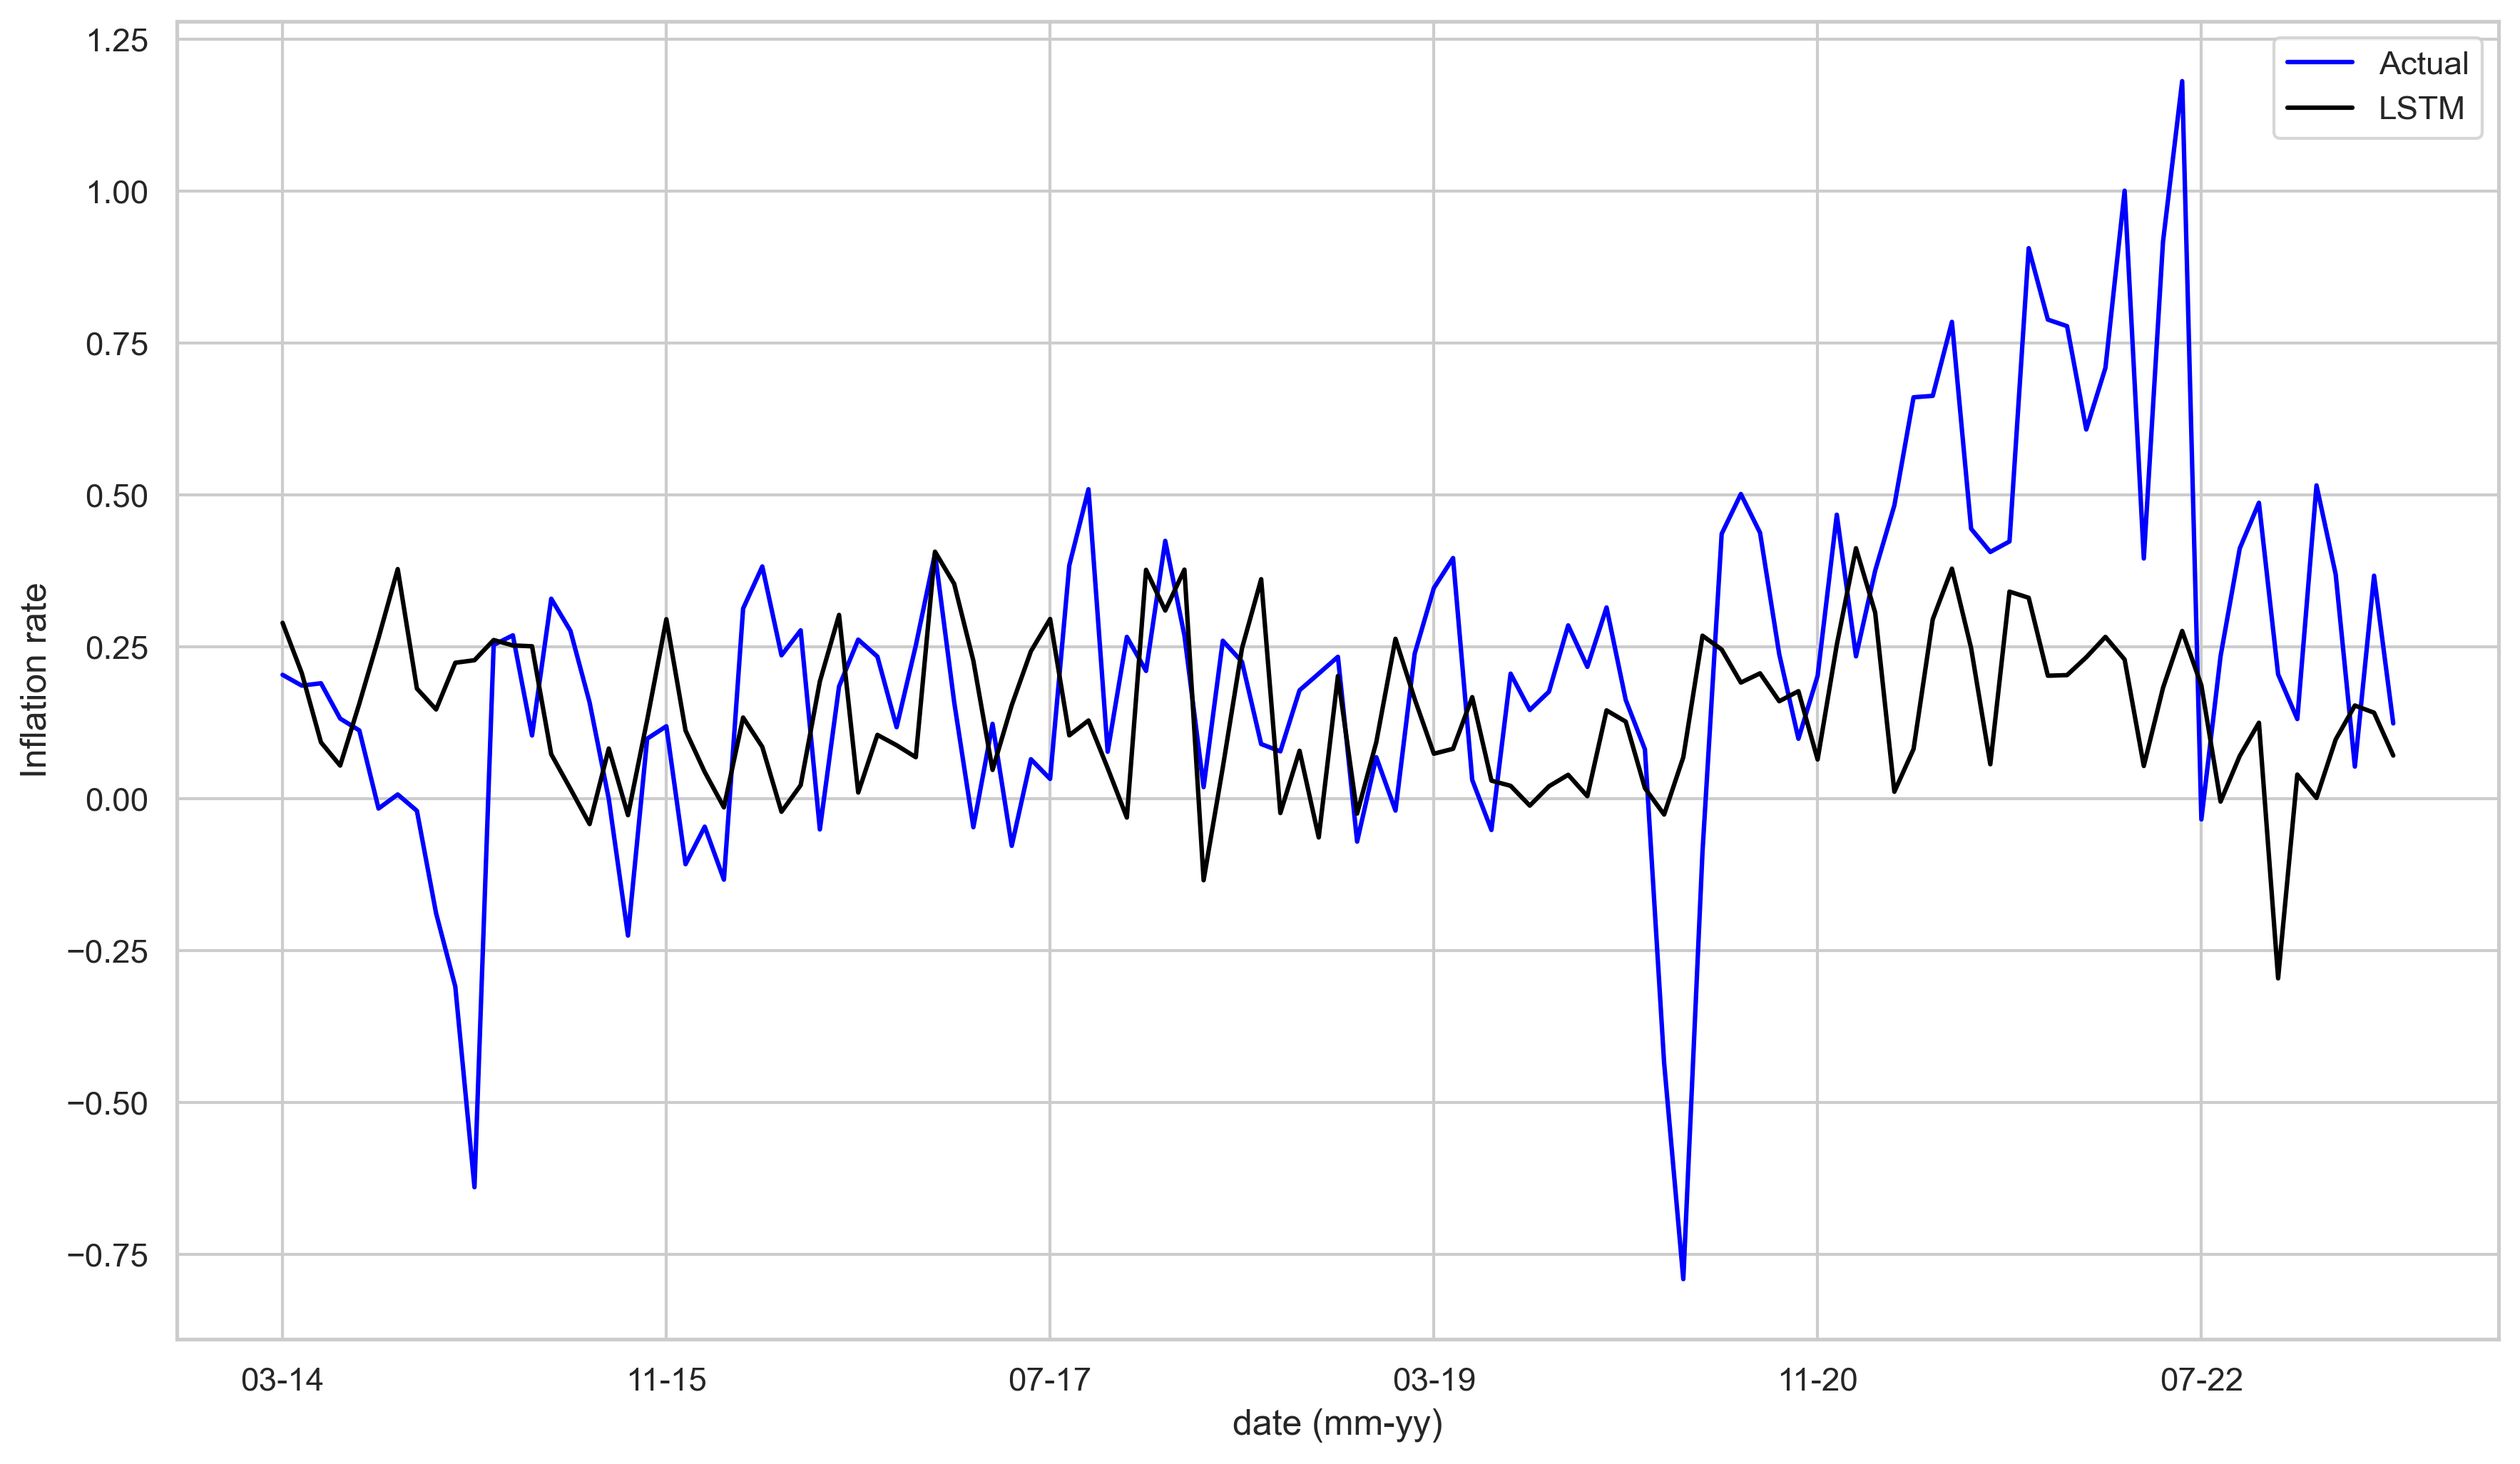

In [109]:
#Define the LSTM model
model = Sequential()
model.add(BatchNormalization())
model.add(LSTM(40, activation='elu', kernel_regularizer="l2", input_shape=(n_steps, n_features)))

model.add(Dropout(0.2))
model.add(Dense(1, activation='linear'))
adam = optimizers.Adam(lr=0.005)
model.compile(optimizer=adam, 
              loss='mean_squared_error',
              metrics=['mse'])
np.random.seed(1)
tf.random.set_seed(2)

#Train the LSTM Model
model_lstm = model.fit(X_train,
                       y_train,
                       batch_size=20, epochs=1000, shuffle=False, verbose=False)

#Predict with test data
LSTM_pred = model.predict(X_test)
LSTM_pred.shape
LSTM_train_pred = model.predict(X_train)

rmse_lstm = np.sqrt(mse(y.iloc[-n:], LSTM_pred))
rmse_lstm

#Calculate the RMSE, correlation and R2
LSTM_pred=pd.DataFrame(LSTM_pred,index=y.iloc[-n:].index)
results=pd.concat([y.iloc[-n:],LSTM_pred],axis=1,ignore_index=True)
results.columns=["Actual","LSTM"]
results.index = pd.DatetimeIndex(results.index).strftime("%d-%y")

print("test error: ", metrics.mean_squared_error(y.iloc[-n:], LSTM_pred,squared=False))
print("train error", metrics.mean_squared_error(y.iloc[:-n-n_steps+1], LSTM_train_pred))
print("Correlation: ",results.corr() )
print("R2: ", metrics.r2_score(y.iloc[-n:], LSTM_pred))


#Plot graph 
(results["Actual"]).plot(color="blue")
(results["LSTM"]).plot(color="black")
plt.legend(["Actual","LSTM"])
plt.xlabel("date (mm-yy)")
plt.ylabel("Inflation rate")
plt.grid(True)
plt.show()

PCA components [40]

Dropout rate [0.2]

Learning rate [0.005]
